## Email Spam Classification

### Problem statement

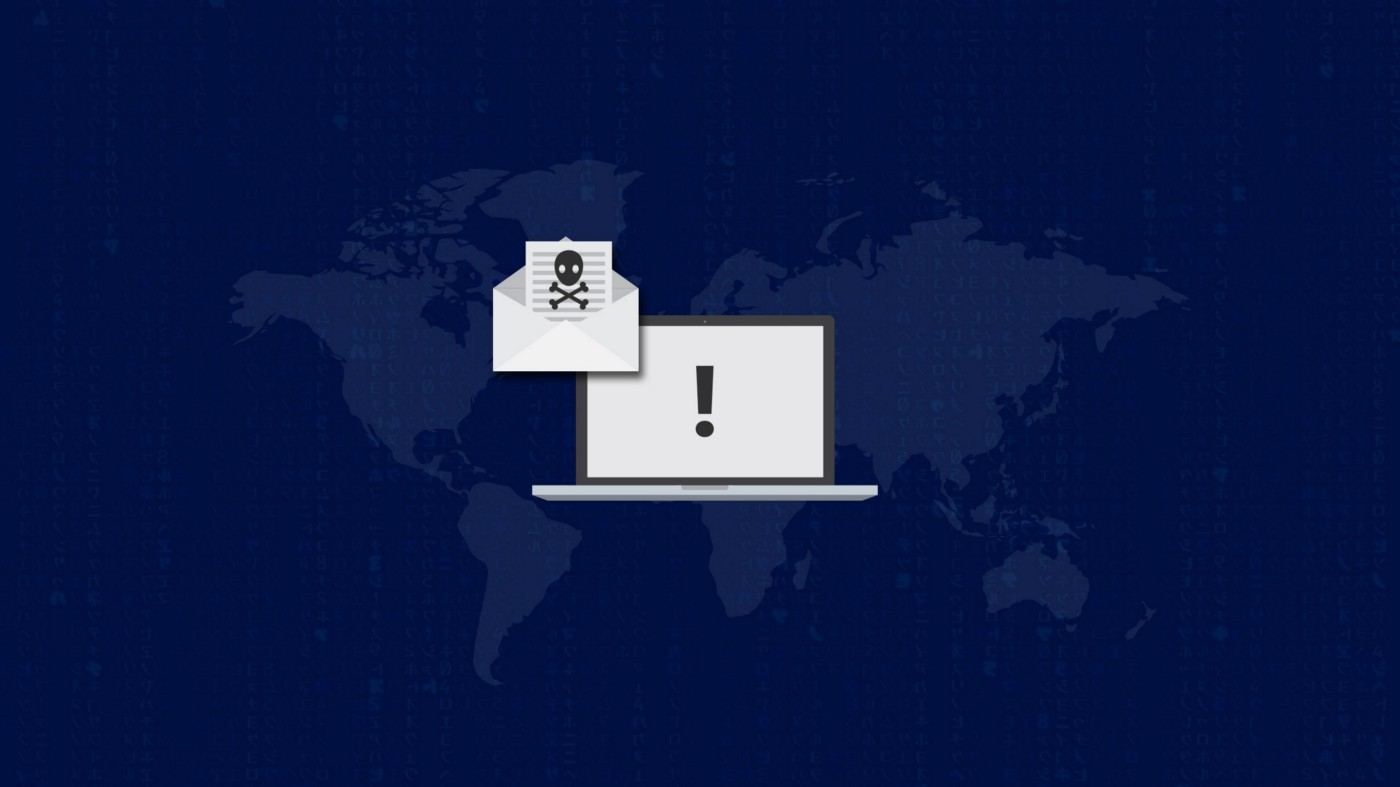

##### A tight competition between filtering method and spammers is going on per day, as spammers began to use tricky methods to overcome the spam filters like using random sender addresses or append random characters at the beginning or end of mails subject line. There is a lack of machine learning focuses on the model development that can predict the activity. Spam is a waste of time to the user since they have to sort the unwanted junk mail and it consumed storage space and communication bandwidth. Rules in other existing must be constantly updated and maintained make it more burden to some user and it is hard to manually compare the accuracy of classified data.

## Importing libraries

In [197]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV)



import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer   ## in order to work with the text 



from sklearn.ensemble import (RandomForestClassifier, 
                             VotingClassifier)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler  # to work with unbalanced data
from imblearn.over_sampling import RandomOverSampler    # to work with unbalanced data
from sklearn.metrics import (roc_auc_score,                ## importing metrics
                            confusion_matrix,
                            accuracy_score,  
                            plot_confusion_matrix,
                            classification_report,
                            balanced_accuracy_score,
                            f1_score,
                            precision_score,
                            recall_score)
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

## Importing dataset

In [198]:
dt = pd.read_csv('./emails.csv')

In [199]:
print("Dataset dimension : {}".format(dt.shape))

Dataset dimension : (5728, 2)


In [200]:
dt.head(10)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
5,"Subject: great nnews hello , welcome to medzo...",1
6,Subject: here ' s a hot play in motion homela...,1
7,Subject: save your money buy getting this thin...,1
8,Subject: undeliverable : home based business f...,1
9,Subject: save your money buy getting this thin...,1


In [201]:
dt.tail(10)

,text,spam
5718,"Subject: altos na gas model kim , i know you ...",0
5719,Subject: power market research i came across ...,0
5720,Subject: re : visit to houston fyi - - - - -...,0
5721,Subject: ees risk management presentations for...,0
5722,Subject: re : vacation vince : i just found ...,0
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0
5727,Subject: news : aurora 5 . 2 update aurora ve...,0


In [202]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [203]:
dt.keys()

Index(['text', 'spam'], dtype='object')

<b>here we can see that we have two types of data which are numerical(wheather it is spam or not) and text(emails)<b>

## Percentage value function

In [204]:
def percent_value_counts(dt, variable):
    percent = pd.DataFrame(round(dt[variable].value_counts(dropna = False, normalize = True)*100, 2))
    total = pd.DataFrame(dt[variable].value_counts(dropna = False))
  
    total.columns = ["Total"]
    percent.columns = ['Percent %']
    return pd.concat([total, percent], axis = 1)

## Data visualization

In [205]:
neg = dt[dt['spam'] == 1] # spam

non_spam = dt[dt['spam'] == 0] ## not spam

neg

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
1363,Subject: are you ready to get it ? hello ! v...,1
1364,Subject: would you like a $ 250 gas card ? do...,1
1365,"Subject: immediate reply needed dear sir , i...",1
1366,Subject: wanna see me get fisted ? fist bang...,1


In [206]:
non_spam

,text,spam
1368,"Subject: hello guys , i ' m "" bugging you "" f...",0
1369,Subject: sacramento weather station fyi - - ...,0
1370,Subject: from the enron india newsdesk - jan 1...,0
1371,Subject: re : powerisk 2001 - your invitation ...,0
1372,Subject: re : resco database and customer capt...,0
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [207]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 

<b> importing library to check most words used in the spam mails and in non spam mails <b>

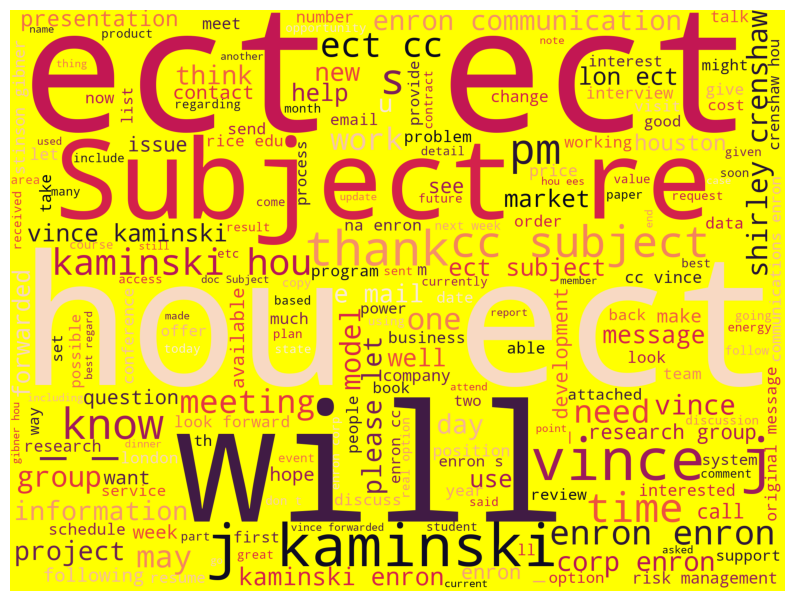

In [208]:
dt_spam = dt[dt['spam'] == 0]['text']
wordcloud_spam = WordCloud(stopwords = STOPWORDS, background_color = 'yellow', width = 2000,
                          height = 1500, colormap = 'rocket_r').generate(" ".join(dt_spam))
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_spam)
plt.axis('off')
plt.show()

<b> here we can see that words such as please, problem, process, work, service and etc. are used in non spam emails <b>

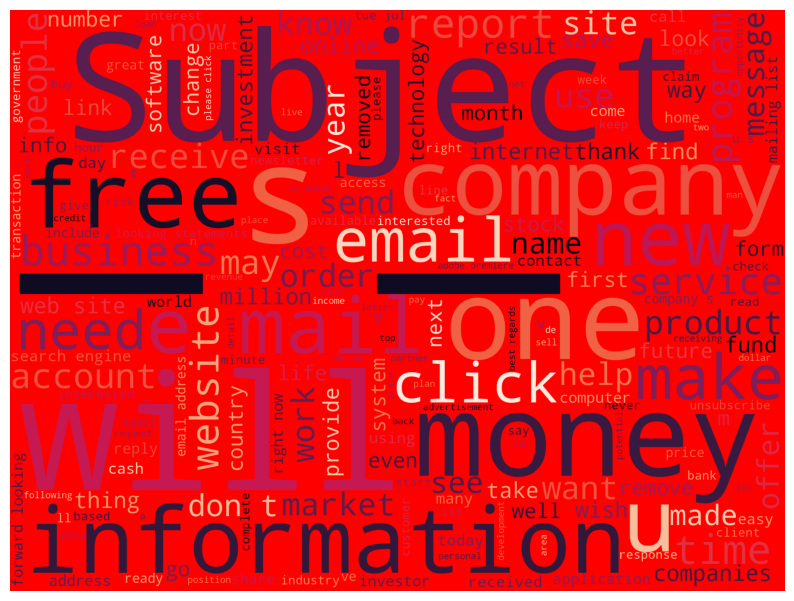

In [209]:
dt_spam = dt[dt['spam'] == 1]['text']
wordcloud_spam = WordCloud(stopwords = STOPWORDS, background_color = 'red', width = 2000,
                          height = 1500, colormap = 'rocket_r').generate(" ".join(dt_spam))
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_spam)
plt.axis('off')
plt.show()

<b> on the other hand here we can see that words like website, time, account, product, people are mostly used in spammed emails <b>

In [210]:
percent_value_counts(dt, 'spam')

,Total,Percent %
0,4360,76.12
1,1368,23.88


<b> As it can be seen from the graph that dataset is unbalanced, moreover the distribution of spam e-mails is much lower than actual e-mails <b>

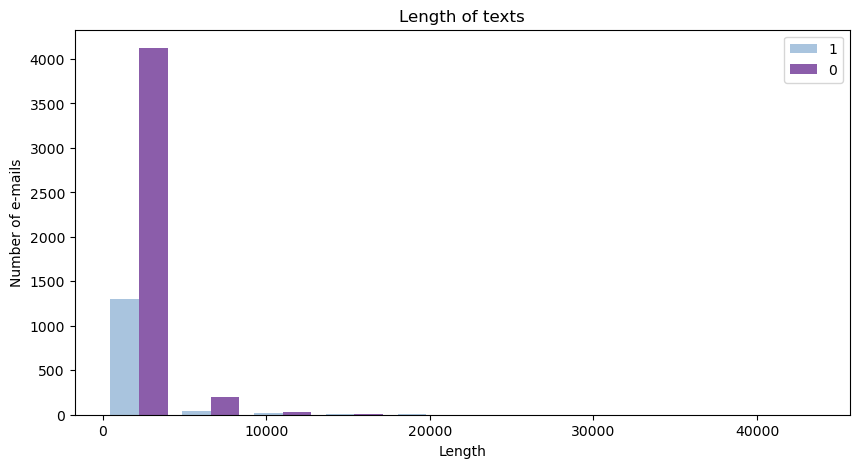

In [211]:
pos_lengths = neg['text'].str.len()
neg_lenghts = non_spam['text'].str.len()

plt.figure(figsize = (10, 5))
colors = sns.color_palette('BuPu', 2) 
plt.hist([pos_lengths, neg_lenghts], label = ['1', '0'], color = colors)
plt.title('Length of texts')
plt.ylabel('Number of e-mails')
plt.xlabel('Length')
plt.legend(loc = 'best')
plt.show()

<b>from this graph as well it can be seen that our dataset is unbalanced, moreover it depicts us that the length of non-spammed emails are rather much higher than the length of spammed emails. Which means that emails with the exact purposes are typed with much more words compared to the spammed ones<b>

In [212]:
dt['length'] = dt['text'].apply(len)
dt.head()

,text,spam,length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,598
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


## Preparing data for training

<b>Applying Count Vectorizer as we need to preprocess text<b>

In [213]:
vectorizer = CountVectorizer()

posneg_vectorizer = vectorizer.fit_transform(dt['text'])

In [214]:
print(vectorizer.get_feature_names())

['00', '000', '0000', '000000', '00000000', '0000000000', '000000000003619', '000000000003991', '000000000003997', '000000000005168', '000000000005409', '000000000005411', '000000000005412', '000000000005413', '000000000005820', '000000000006238', '000000000006452', '000000000007494', '000000000007498', '000000000007876', '000000000010552', '000000000011185', '000000000012677', '000000000012734', '000000000012735', '000000000012736', '000000000012738', '000000000012741', '000000000012987', '000000000013085', '000000000013287', '000000000015384', '000000000015793', '000000000023619', '000000000024099', '000000000025307', '000000000025312', '000010220', '0000102317', '0000102374', '0000102789', '0000104281', '0000104282', '0000104486', '0000104631', '0000104730', '0000104776', '0000104778', '0000107043', '0000108729', '000066', '0001', '000166', '0002', '000202', '0003', '0004', '0005', '0006', '00076', '0009249480', '0009249481', '0009249504', '0009249505', '0009249506', '001', '0011', 

In [215]:
posneg_vectorizer.shape

(5728, 37303)

## Dividing our dataset into training/test set

In [216]:
label = dt['spam']

In [217]:
x = posneg_vectorizer

y = label

x.shape, y.shape

((5728, 37303), (5728,))

<b> here our 'x' equals to texts while 'y' equals to labels as of 1 or 0(spam or non-spam)<b>

In [218]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                   random_state = 0)
x_train.shape, x_test.shape

((4582, 37303), (1146, 37303))

<b>Dividing our dataset into training and test sets<b>

In [219]:
y_train.head(10)

4518    0
4472    0
799     1
4809    0
1043    1
562     1
95      1
2724    0
1050    1
3262    0
Name: spam, dtype: int64

## Model training & Searching hyperparameters with Grid-Search CV

In [220]:
# To save the model results into lists

model_list = []    # models names

roc_auc_score_list = []
balanced_accuracy_list = []    #scoring for unbalanced dataset
geometric_mean_list = []       #scoring for unbalanced dataset
precision_score_list = []
recall_score_list = []
f1_score_list = []
classification_report_imbalanced_list = []

<b> creating lists so that we can save our model results into them and then compare their results<b>

### Logistic Regression

In [221]:
log_reg = LogisticRegression(random_state = 0, class_weight = 'balanced', C = 0.01)

<b> in LogisticRegression class_weight = 'balanced' parameter was used as our dataset is unbalanced <b>

In [222]:
log_reg_param_grid = {'penalty': ['l1'],
                 'solver': ['liblinear'],
                 'max_iter': [100, 200, 300],
                 'dual': [False]
                  }

In [223]:
log_reg_grid_search = GridSearchCV(estimator = log_reg, 
                              param_grid = log_reg_param_grid, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [224]:
%%timeit -r 1 -n 1

log_reg_grid_search.fit(x_train, y_train)

732 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [225]:
log_reg_grid_search.best_params_

{'dual': False, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

<b>after training the model we draw out the best parameters through grid_search_cv <b>

### Logistic Regression Model Estimating

In [226]:
log_reg_y_pred_train = log_reg_grid_search.predict(x_train)
log_reg_y_pred_train

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

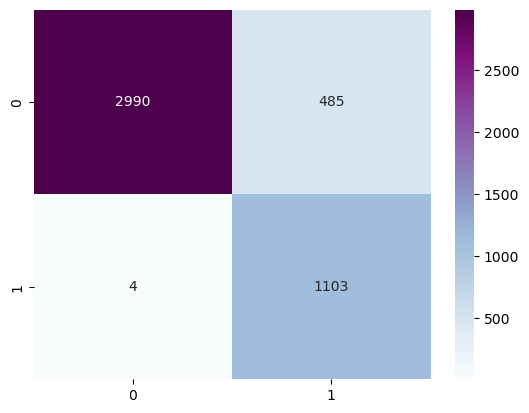

In [227]:
log_reg_cm = confusion_matrix(y_train, log_reg_y_pred_train)
sns.heatmap(log_reg_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b>creating a heatmap of a confusion matrix for the train set<b>

In [228]:
log_reg_y_pred_test = log_reg_grid_search.predict(x_test)
log_reg_y_pred_test

array([0, 0, 1, ..., 0, 1, 1])

<AxesSubplot:>

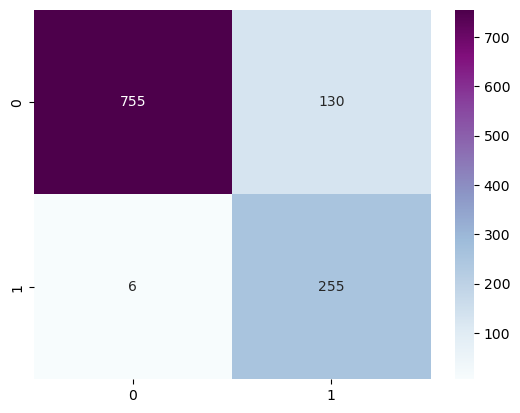

In [229]:
log_reg_cm = confusion_matrix(y_test, log_reg_y_pred_test)
sns.heatmap(log_reg_cm, annot = True, fmt = 'd', cmap = "BuPu")

<b> creating a heatmap of a confusion matrix for the test set<b>

In [230]:
log_reg_roc_auc_score = roc_auc_score(y_test, log_reg_y_pred_test)
log_reg_roc_auc_score

0.915059419442821

In [231]:
log_reg_classification_report = classification_report_imbalanced(y_test, log_reg_y_pred_test)
                                                      
print(log_reg_classification_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.85      0.98      0.92      0.91      0.82       885
          1       0.66      0.98      0.85      0.79      0.91      0.84       261

avg / total       0.92      0.88      0.95      0.89      0.91      0.83      1146



<b> by looking at this classification report we can see that total precision score is showing 97 percent, which means that it is quite good<b> 

In [232]:
log_reg_geometric_mean = geometric_mean_score(y_test, log_reg_y_pred_test)
print(log_reg_geometric_mean)

0.9129598466185478


In [233]:
log_reg_precision_score = precision_score(y_test, log_reg_y_pred_test)
log_reg_precision_score

0.6623376623376623

In [234]:
log_reg_f1_score = f1_score(y_test, log_reg_y_pred_test)
log_reg_f1_score

0.7894736842105263

In [235]:
log_reg_recall_score = recall_score(y_test, log_reg_y_pred_test)
log_reg_recall_score

0.9770114942528736

<b> all other metris results also depicts good scores, and in the end we will be comparing all models metrics scores and see which fits the most<b>

In [236]:
# Saving the model results into lists
model_list.append('Logistic Regression (Imbalanced)')
roc_auc_score_list.append(round(roc_auc_score(y_test, log_reg_y_pred_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, log_reg_y_pred_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, log_reg_y_pred_test), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, log_reg_y_pred_test), 3))
f1_score_list.append(round(f1_score(y_test, log_reg_y_pred_test), 3))
precision_score_list.append(round(precision_score(y_test, log_reg_y_pred_test), 3))
recall_score_list.append(round(recall_score(y_test, log_reg_y_pred_test), 3))

## Logistic Regression with OverSampling

<b> Oversampling — Duplicating samples from the minority class.
Undersampling — Deleting samples from the majority class.<b>

In [237]:
random_os = RandomOverSampler(random_state = 0)
x_train_os, y_train_os = random_os.fit_resample(x_train, y_train)

<b> here we are resampling our data into OverSampler<b>

In [238]:
log_reg_os = LogisticRegression(random_state = 0, 
                        penalty = 'l1', 
                        solver = 'liblinear', 
                        max_iter = 100,
                        dual = True)

<b> LogisticRegression with OverSampling method <b>

In [239]:
log_reg_params_os =              {'penalty': ['l1'],
                                 'solver': ['liblinear'],
                                 'max_iter': [100, 200, 300],
                                 'dual': [False]
                                  }

In [240]:
log_reg_grid_search_os = GridSearchCV(estimator = log_reg_os, 
                              param_grid = log_reg_params_os, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [241]:
%%timeit -r 1 -n 1

log_reg_grid_search_os.fit(x_train_os, y_train_os)

1.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [242]:
log_reg_grid_search_os.best_params_

{'dual': False, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

<b> drawing out the best suited parameters through GridSearch<b>

## Estimating Logistic Regression Oversampled

In [243]:
lr_y_pred_train_os = log_reg_grid_search_os.predict(x_train_os)
lr_y_pred_train_os

array([0, 0, 1, ..., 1, 1, 1])

<AxesSubplot:>

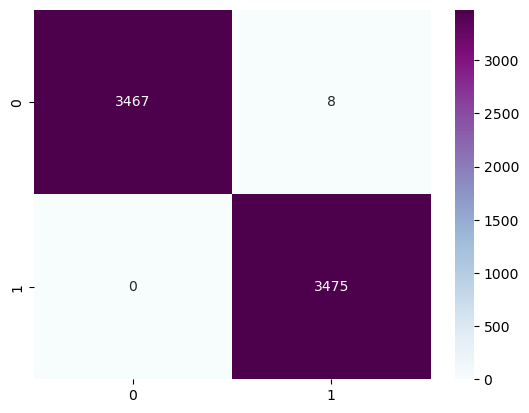

In [244]:
lr_cm_os = confusion_matrix(y_train_os, lr_y_pred_train_os)
sns.heatmap(lr_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b>creating a heatmap of a confusion matrix for the train set<b>

In [245]:
lr_y_pred_test_os = log_reg_grid_search_os.predict(x_test)
lr_y_pred_test_os

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

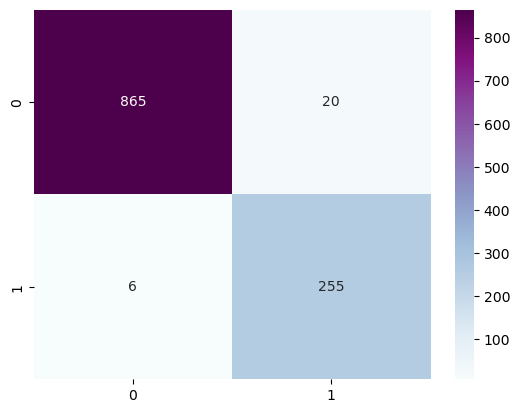

In [246]:
lr_cm_os = confusion_matrix(y_test, lr_y_pred_test_os)
sns.heatmap(lr_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b> creating a heatmap of a confusion matrix for the test set<b>

In [247]:
lr_roc_auc_score_os = roc_auc_score(y_test, lr_y_pred_test_os)
lr_roc_auc_score_os

0.9772063120981882

In [248]:
lr_classification_report_os = classification_report(y_test, lr_y_pred_test_os)
                                                      
print(lr_classification_report_os)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       885
           1       0.93      0.98      0.95       261

    accuracy                           0.98      1146
   macro avg       0.96      0.98      0.97      1146
weighted avg       0.98      0.98      0.98      1146



<b> classification report as well with quite good results<b>

In [249]:
lr_balanced_acc_score_os = balanced_accuracy_score(y_test, lr_y_pred_test_os)
print(lr_balanced_acc_score_os)

0.9772063120981882


In [250]:
lr_geometric_mean_os = geometric_mean_score(y_test, lr_y_pred_test_os)
print(lr_geometric_mean_os)

0.9772062926785463


In [251]:
lr_class_report_imbalanced_os = classification_report_imbalanced(y_test, lr_y_pred_test_os)
print(lr_class_report_imbalanced_os)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.98      0.98      0.99      0.98      0.95       885
          1       0.93      0.98      0.98      0.95      0.98      0.95       261

avg / total       0.98      0.98      0.98      0.98      0.98      0.95      1146



In [252]:
lr_precision_score_os = precision_score(y_test, lr_y_pred_test_os)
lr_precision_score_os

0.9272727272727272

In [253]:
lr_f1_score_os = f1_score(y_test, lr_y_pred_test_os)
lr_f1_score_os

0.9514925373134328

In [254]:
lr_recall_score_os = recall_score(y_test, lr_y_pred_test_os)
lr_recall_score_os

0.9770114942528736

<b>metrics are with the good results too<b>

In [255]:
# Saving the model results into lists
model_list.append('Logistic Regression (OverSampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, lr_y_pred_test_os), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, lr_y_pred_test_os), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, lr_y_pred_test_os), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, lr_y_pred_test_os), 3))
f1_score_list.append(round(f1_score(y_test, lr_y_pred_test_os), 3))
precision_score_list.append(round(precision_score(y_test, lr_y_pred_test_os), 3))
recall_score_list.append(round(recall_score(y_test, lr_y_pred_test_os), 3))

## Logistic Regression With UnderSampling

In [256]:
random_us = RandomUnderSampler(random_state = 10)
x_train_us, y_train_us = random_us.fit_resample(x_train, y_train)

<b> resamling train sets into Under Sampler <b>

In [257]:
log_reg_us = LogisticRegression(random_state = 0, 
                        penalty = 'l1', 
                        solver = 'liblinear', 
                        max_iter = 100,
                        dual = True)

In [258]:
log_reg_params_us =              {'penalty': ['l1'],
                                 'solver': ['liblinear'],
                                 'max_iter': [100, 200, 300],
                                 'dual': [False]
                                  }

In [259]:
log_reg_grid_search_us = GridSearchCV(estimator = log_reg_us, 
                              param_grid = log_reg_params_us, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [260]:
%%timeit -r 1 -n 1

log_reg_grid_search_us.fit(x_train_us, y_train_us)

470 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [261]:
log_reg_grid_search_us.best_params_

{'dual': False, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

<b> drawing out models best parameters through GridSearch <b>

## Logistic Regression Model Estimating with UnderSampler

In [262]:
lr_us_y_pred_train = log_reg_grid_search_us.predict(x_train_us)
lr_us_y_pred_train

array([0, 0, 0, ..., 1, 1, 1])

<AxesSubplot:>

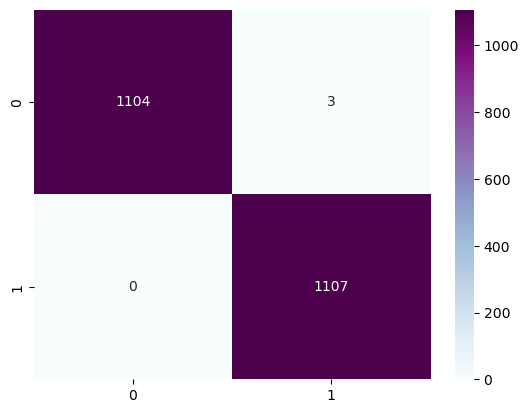

In [263]:
lr_us_cm = confusion_matrix(y_train_us, lr_us_y_pred_train)
sns.heatmap(lr_us_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b> Creating a heatmap of a confusion matrix for the train set. <b>

In [264]:
lr_us_y_pred_test = log_reg_grid_search_us.predict(x_test)
lr_us_y_pred_test

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

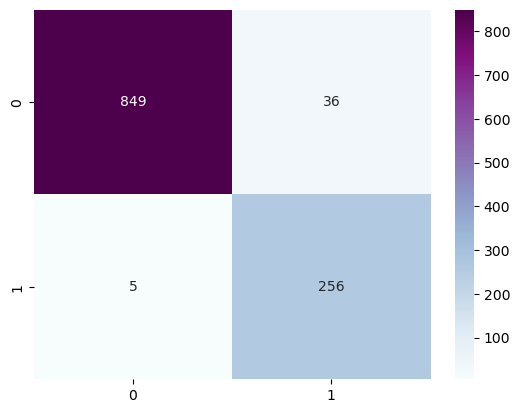

In [265]:
lr_us_cm = confusion_matrix(y_test, lr_us_y_pred_test)
sns.heatmap(lr_us_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b> creating a heatmap of a confusion matrix for the test set <b>

In [266]:
lr_us_roc_auc_score = roc_auc_score(y_test, lr_us_y_pred_test)
lr_us_roc_auc_score

0.9700824728878497

In [267]:
lr_us_classification_report = classification_report(y_test, lr_us_y_pred_test)
                                                      
print(lr_us_classification_report)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       885
           1       0.88      0.98      0.93       261

    accuracy                           0.96      1146
   macro avg       0.94      0.97      0.95      1146
weighted avg       0.97      0.96      0.96      1146



<b> classification report with good scores <b>

In [268]:
lr_us_class_imbalanced_report = classification_report_imbalanced(y_test, lr_us_y_pred_test)

print(lr_us_class_imbalanced_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.96      0.98      0.98      0.97      0.94       885
          1       0.88      0.98      0.96      0.93      0.97      0.94       261

avg / total       0.97      0.96      0.98      0.96      0.97      0.94      1146



In [269]:
lr_us_balanced_acc_score = balanced_accuracy_score(y_test, lr_us_y_pred_test)
print(lr_us_balanced_acc_score)

0.9700824728878499


In [270]:
lr_us_geometric_mean = geometric_mean_score(y_test, lr_us_y_pred_test)
print(lr_us_geometric_mean)

0.9700227920811748


In [271]:
lr_us_f1_score = f1_score(y_test, lr_us_y_pred_test)
lr_us_f1_score

0.9258589511754068

In [272]:
lr_us_precision_score = precision_score(y_test, lr_us_y_pred_test)
lr_us_precision_score

0.8767123287671232

In [273]:
lr_us_recall_score = recall_score(y_test, lr_us_y_pred_test)
lr_us_recall_score

0.9808429118773946

<b> here we can observe metrics scores <b>

In [274]:
# Save the model results into lists
model_list.append('Logistic Regression (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, lr_us_y_pred_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, lr_us_y_pred_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, lr_us_y_pred_test), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, lr_us_y_pred_test), 3))
f1_score_list.append(round(f1_score(y_test, lr_us_y_pred_test), 3))
precision_score_list.append(round(precision_score(y_test, lr_us_y_pred_test), 3))
recall_score_list.append(round(recall_score(y_test, lr_us_y_pred_test), 3))

## Confusion matrix: Logistic Regression

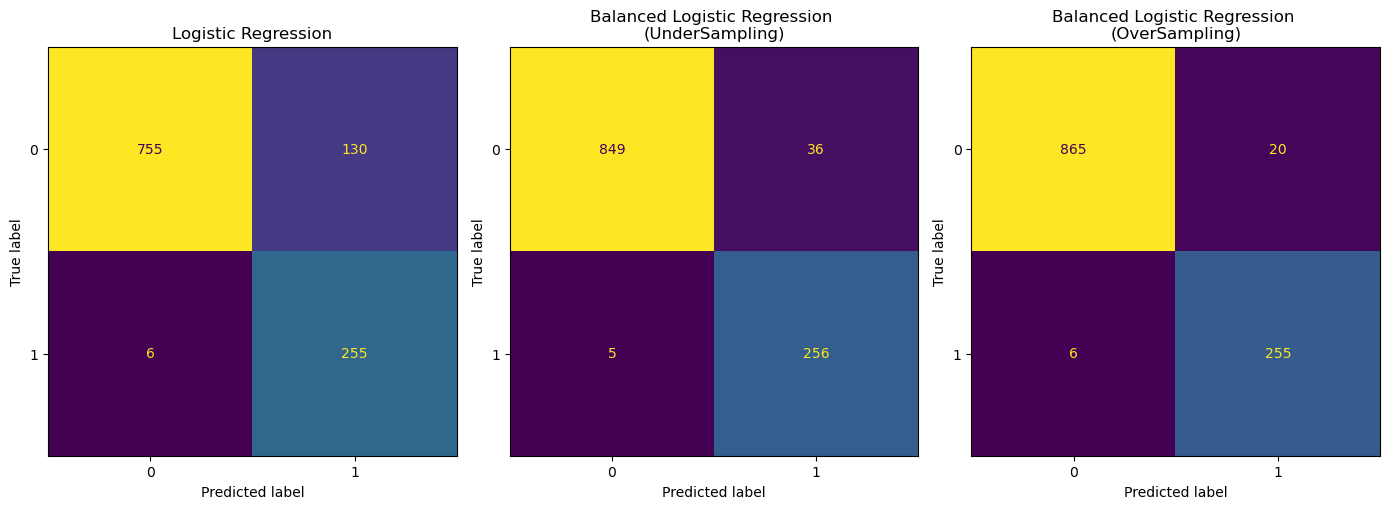

In [275]:
fig, axs = plt.subplots(ncols = 3, figsize = (14, 7))
plot_confusion_matrix(log_reg_grid_search, x_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Logistic Regression")

plot_confusion_matrix(log_reg_grid_search_us, x_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Logistic Regression \n(UnderSampling)")

plot_confusion_matrix(log_reg_grid_search_os, x_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Logistic Regression \n(OverSampling)")

fig.tight_layout()

<b>creating a figure with three subplots, each showing a confusion matrix for different versions of logistic regression models.<b> 

## Decision Tree Classifier 

In [276]:
DTC = DecisionTreeClassifier(random_state = 0,
                            max_depth = [5],
                            criterion = 'gini',
                            min_samples_split = 2,
                            class_weight = 'balanced')

<b>Decision tree was chosen here because it also has parameter class_weight = 'balanced', as dataset is unbalanced.<b>

In [277]:
DTC_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [8, 10, 12],
    'max_features': ['sqrt'],
}

In [278]:
DTC_grid_search = GridSearchCV(estimator = DTC, 
                              param_grid = DTC_param_grid, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

<b> here GridSearchCV scoring parameter was chosen accuracy<b>

In [279]:
%%timeit -r 1 -n 1

DTC_grid_search.fit(x_train, y_train)

725 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [280]:
DTC_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'splitter': 'random'}

## Decision Tree Classifier Estimating

In [281]:
DTC_y_pred_train = DTC_grid_search.predict(x_train)
DTC_y_pred_train

array([1, 1, 1, ..., 1, 1, 1])

<AxesSubplot:>

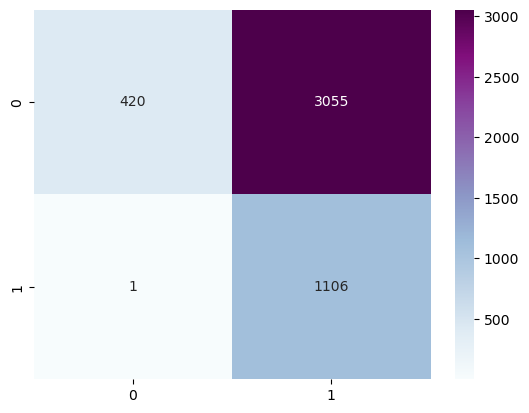

In [282]:
DTC_cm = confusion_matrix(y_train, DTC_y_pred_train)
sns.heatmap(DTC_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b> creating a heatmap of a confusion matrix for the train set<b>

In [283]:
DTC_y_pred_test = DTC_grid_search.predict(x_test)
DTC_y_pred_test

array([1, 1, 1, ..., 1, 1, 1])

<AxesSubplot:>

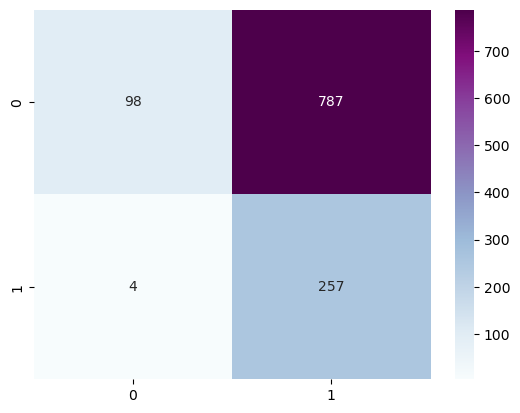

In [284]:
DTC_cm = confusion_matrix(y_test, DTC_y_pred_test)
sns.heatmap(DTC_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b> creating a heatmap of a confusion matrix for the test set<b>

In [285]:
DTC_roc_auc_score = roc_auc_score(y_test, DTC_y_pred_test)
DTC_roc_auc_score

0.5477043963893758

roc_auc is just with 50 percent score

In [286]:
DTC_classification_report = classification_report_imbalanced(y_test, DTC_y_pred_test)
                                                      
print(DTC_classification_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.11      0.98      0.20      0.33      0.10       885
          1       0.25      0.98      0.11      0.39      0.33      0.12       261

avg / total       0.80      0.31      0.79      0.24      0.33      0.10      1146



In [287]:
DTC_geometric_mean = geometric_mean_score(y_test, DTC_y_pred_test)
print(DTC_geometric_mean)

0.330208091027269


In [288]:
DTC_f1_score = f1_score(y_test, DTC_y_pred_test)
DTC_f1_score

0.39386973180076623

In [289]:
DTC_precision_score = precision_score(y_test, DTC_y_pred_test)
DTC_precision_score

0.24616858237547892

In [290]:
DTC_recall_score = recall_score(y_test, DTC_y_pred_test)
DTC_recall_score

0.9846743295019157

<b> checking metrics scores above <b>

## Decision Tree Classifier with UnderSampling

<b> after training Decision Tree and checking results with the metrics. it was obvious that Decision tree was not a good fit.  Checking for the results with UnderSampling<b>

In [291]:
DTC_us = DecisionTreeClassifier(random_state = 0,
                            max_depth = [5],
                            criterion = 'gini',
                            min_samples_split = 2,
                            class_weight = 'balanced')

In [292]:
DTC_param_grid_us = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [8, 10, 12],
    'max_features': ['sqrt'],
}

In [293]:
DTC_grid_search_us = GridSearchCV(estimator = DTC_us, 
                              param_grid = DTC_param_grid_us, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

<b> all decision tree parameters remained the same <b>

In [294]:
%%timeit -r 1 -n 1

DTC_grid_search_us.fit(x_train_us, y_train_us)

446 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [295]:
DTC_grid_search_us.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'splitter': 'best'}

<b> checking for best suited parameters <b>

## Estimating Decision Tree Classifier UnderSampled

In [296]:
DTC_y_pred_train_us = DTC_grid_search_us.predict(x_train_us)
DTC_y_pred_train_us

array([0, 0, 0, ..., 1, 0, 1])

<AxesSubplot:>

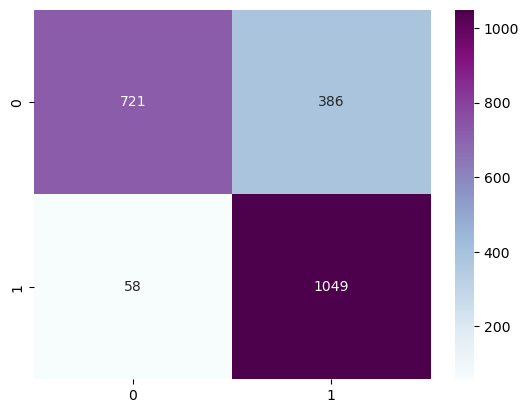

In [297]:
DTC_cm_us = confusion_matrix(y_train_us, DTC_y_pred_train_us)
sns.heatmap(DTC_cm_us, annot = True, fmt = 'd', cmap = 'BuPu')

<b> creating a heatmap of a confusion matrix for the train set

In [298]:
DTC_y_pred_test_us = DTC_grid_search_us.predict(x_test)
DTC_y_pred_test_us

array([0, 1, 1, ..., 1, 1, 1])

<AxesSubplot:>

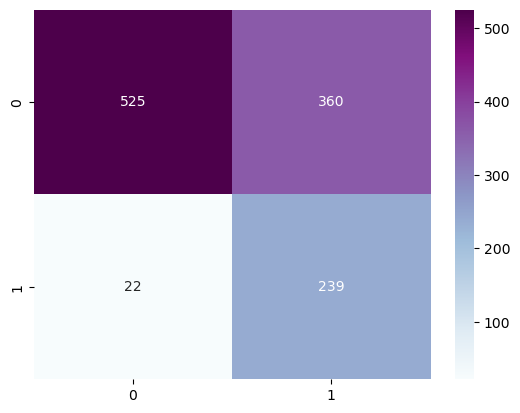

In [299]:
DTC_cm_us = confusion_matrix(y_test, DTC_y_pred_test_us)
sns.heatmap(DTC_cm_us, annot = True, fmt = 'd', cmap = 'BuPu')

<b>creating a heatmap of a confusion matrix for the test set<b>

In [300]:
DTC_roc_auc_score_us = roc_auc_score(y_test, DTC_y_pred_test_us)
DTC_roc_auc_score_us

0.7544645756217936

In [301]:
DTC_balanced_acc_score_us = balanced_accuracy_score(y_test, DTC_y_pred_test_us)
print(DTC_balanced_acc_score_us)

0.7544645756217936


In [302]:
DTC_classification_report_us = classification_report(y_test, DTC_y_pred_test_us)
print(DTC_classification_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.11      0.98      0.20      0.33      0.10       885
          1       0.25      0.98      0.11      0.39      0.33      0.12       261

avg / total       0.80      0.31      0.79      0.24      0.33      0.10      1146



In [303]:
DTC_geometric_mean_us = geometric_mean_score(y_test, DTC_y_pred_test_us)
print(DTC_geometric_mean_us)

0.7370326261563745


In [304]:
DTC_imbalanced_class_rep = classification_report_imbalanced(y_test, DTC_y_pred_test_us)
print(DTC_imbalanced_class_rep)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.59      0.92      0.73      0.74      0.53       885
          1       0.40      0.92      0.59      0.56      0.74      0.56       261

avg / total       0.83      0.67      0.84      0.69      0.74      0.53      1146



In [305]:
DTC_f1_score_us = f1_score(y_test, DTC_y_pred_test_us)
DTC_f1_score_us

0.5558139534883721

In [306]:
DTC_precision_score_us = precision_score(y_test, DTC_y_pred_test_us)
DTC_precision_score_us

0.3989983305509182

In [307]:
DTC_recall_score_us = recall_score(y_test, DTC_y_pred_test_us)
DTC_recall_score_us

0.9157088122605364

<b> here it can observed that the metrics scores have improved <b>

## Decision Tree Classifier with OverSampling

<b> Trying to build a model DTC with OverSampling method, to see if it can be improved and show better results <b> 

In [308]:
DTC_os = DecisionTreeClassifier(random_state = 0,
                            max_depth = [5],
                            criterion = 'gini',
                            min_samples_split = 2,
                            class_weight = 'balanced')

<b> in this case as well class_weight = 'balanced' parameter was chosen in order to make data as balanced as possible <b>

In [309]:
DTC_param_grid_os = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [8, 10, 12],
    'max_features': ['sqrt'],
}

In [310]:
DTC_grid_search_os = GridSearchCV(estimator = DTC_os, 
                              param_grid = DTC_param_grid_os, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [311]:
%%timeit -r 1 -n 1

DTC_grid_search_os.fit(x_train_os, y_train_os)

1.19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [312]:
DTC_grid_search_os.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'splitter': 'best'}

## Estimating Decision Tree Classifier with OverSampling 

In [313]:
DTC_y_pred_train_os = DTC_grid_search_os.predict(x_train_os)
DTC_y_pred_train_os

array([0, 0, 1, ..., 1, 0, 1])

<AxesSubplot:>

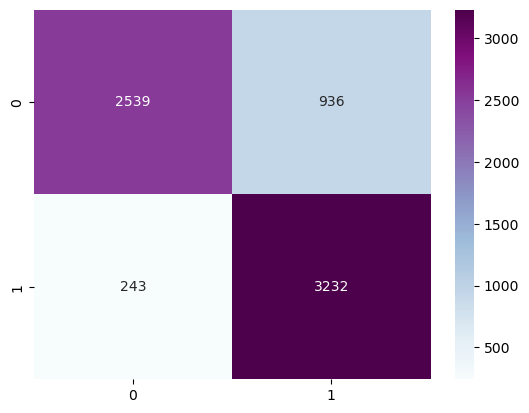

In [314]:
DTC_cm_os = confusion_matrix(y_train_os, DTC_y_pred_train_os)
sns.heatmap(DTC_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b> creating a heatmap of a confusion matrix for the train set <b>

In [315]:
DTC_y_pred_test_os = DTC_grid_search_os.predict(x_test)
DTC_y_pred_test_os

array([0, 0, 1, ..., 0, 1, 1])

<AxesSubplot:>

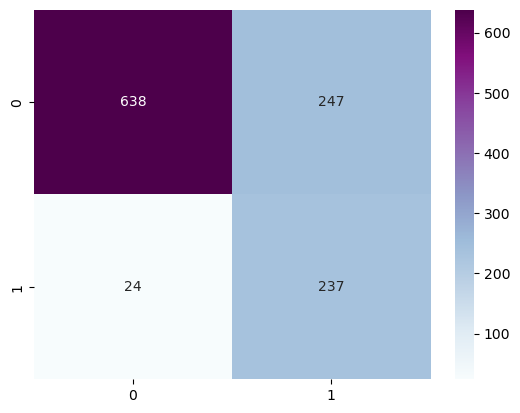

In [316]:
DTC_cm_os = confusion_matrix(y_test, DTC_y_pred_test_os)
sns.heatmap(DTC_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b> creating a heatmap of a confusion matrix for the test set <b>

In [317]:
DTC_roc_auc_score_os = roc_auc_score(y_test, DTC_y_pred_test_os)
DTC_roc_auc_score_os

0.8144749659068771

In [318]:
DTC_balanced_acc_score_os = balanced_accuracy_score(y_test, DTC_y_pred_test_os)
print(DTC_balanced_acc_score_os)

0.8144749659068771


In [319]:
DTC_classification_report_os = classification_report(y_test, DTC_y_pred_test_os)
print(DTC_classification_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.11      0.98      0.20      0.33      0.10       885
          1       0.25      0.98      0.11      0.39      0.33      0.12       261

avg / total       0.80      0.31      0.79      0.24      0.33      0.10      1146



In [320]:
DTC_class_report_imbalanced_os = classification_report_imbalanced(y_test, DTC_y_pred_test_os)

print(DTC_class_report_imbalanced_os)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.72      0.91      0.82      0.81      0.64       885
          1       0.49      0.91      0.72      0.64      0.81      0.67       261

avg / total       0.86      0.76      0.87      0.78      0.81      0.65      1146



In [321]:
DTC_geometric_mean_os = geometric_mean_score(y_test, DTC_y_pred_test_os)
print(DTC_geometric_mean_os)

0.8090821565019638


In [322]:
DTC_f1_score_os = f1_score(y_test, DTC_y_pred_test_os)
DTC_f1_score_os

0.636241610738255

In [323]:
DTC_precision_score_os = precision_score(y_test, DTC_y_pred_test_os)
DTC_precision_score_os

0.4896694214876033

In [324]:
DTC_recall_score = recall_score(y_test, DTC_y_pred_test_os)
DTC_recall_score

0.9080459770114943

## Confusion matrix for all three models with DTC

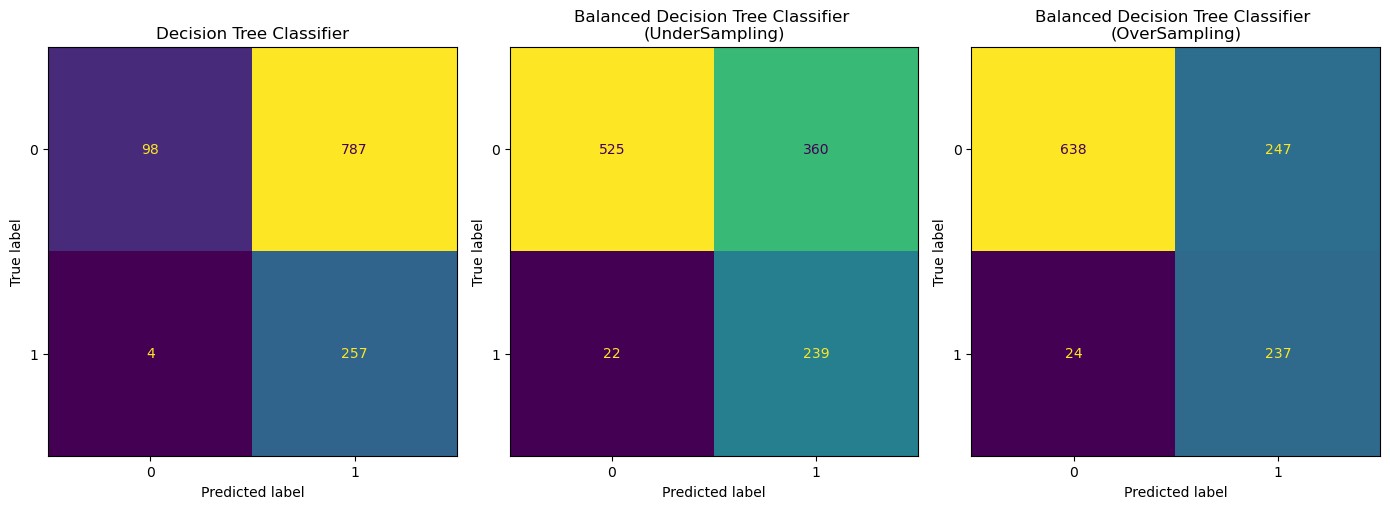

In [325]:
fig, axs = plt.subplots(ncols = 3, figsize = (14, 7))
plot_confusion_matrix(DTC_grid_search, x_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Decision Tree Classifier")

plot_confusion_matrix(DTC_grid_search_us, x_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Decision Tree Classifier \n(UnderSampling)")

plot_confusion_matrix(DTC_grid_search_os, x_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Decision Tree Classifier \n(OverSampling)")

fig.tight_layout()

<b> creating a figure with three subplots, each showing a confusion matrix for a different versions of a Decision tree Classifier models.

## Random Forest Classifier

In [326]:
RFC = RandomForestClassifier(n_estimators = 100,
                            random_state = 0,
                            n_jobs = -1,
                            max_features = 'sqrt',
                            criterion  ='gini',
                            class_weight = 'balanced')

<b> RandomForest Classifier as well was chosen mainly because it has parameter class_weight = 'balanced' <b>

In [327]:
RFC_param_grid = {
    'n_estimators': [100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 5, 8],
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1]
}

In [328]:
RFC_grid_search = GridSearchCV(estimator = RFC, 
                              param_grid = RFC_param_grid, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [329]:
%%timeit -r 1 -n 1

RFC_grid_search.fit(x_train, y_train)

1min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [330]:
RFC_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'n_estimators': 100,
 'n_jobs': -1}

<b> checking for the best parameters through GridSearchCV <b>

## Random Forest Classifier Model Estimating

In [331]:
RFC_y_pred_train = RFC_grid_search.predict(x_train)
RFC_y_pred_train

array([0, 0, 1, ..., 0, 0, 0])

<AxesSubplot:>

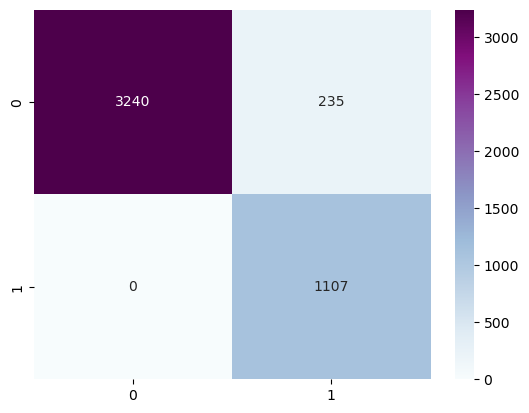

In [332]:
RFC_cm = confusion_matrix(y_train, RFC_y_pred_train)
sns.heatmap(RFC_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b>creating a heatmap of a confusion matrix for the train set <b>

In [333]:
RFC_y_pred_test = RFC_grid_search.predict(x_test)
RFC_y_pred_test

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

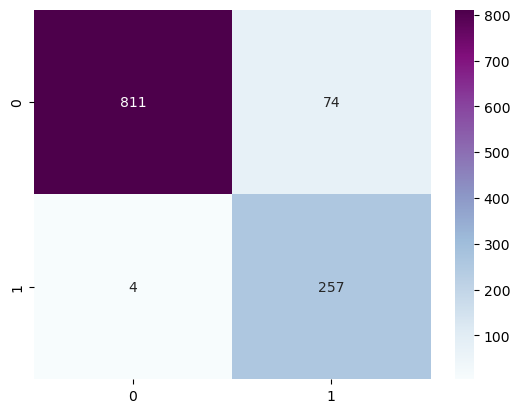

In [334]:
RFC_cm = confusion_matrix(y_test, RFC_y_pred_test)
sns.heatmap(RFC_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the test set <b>

In [335]:
RFC_roc_auc_score = roc_auc_score(y_test, RFC_y_pred_test)
RFC_roc_auc_score

0.950529255146438

In [336]:
RFC_classification_report = classification_report_imbalanced(y_test, RFC_y_pred_test)
                                                      
print(RFC_classification_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.92      0.98      0.95      0.95      0.90       885
          1       0.78      0.98      0.92      0.87      0.95      0.91       261

avg / total       0.95      0.93      0.97      0.93      0.95      0.90      1146



In [337]:
RFC_geometric_mean = geometric_mean_score(y_test, RFC_y_pred_test)

print(RFC_geometric_mean)

0.9499157745750416


In [338]:
RFC_f1_score = f1_score(y_test, RFC_y_pred_test)
RFC_f1_score

0.8682432432432433

In [339]:
RFC_precision_score = precision_score(y_test, RFC_y_pred_test)
RFC_precision_score

0.7764350453172205

In [340]:
RFC_recall_score = recall_score(y_test, RFC_y_pred_test)
RFC_recall_score

0.9846743295019157

<b>checking for metrics scores<b>

In [341]:
# Save the model results into lists
model_list.append('Random Forest CLassifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, RFC_y_pred_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, RFC_y_pred_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, RFC_y_pred_test), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, RFC_y_pred_test), 3))
f1_score_list.append(round(f1_score(y_test, RFC_y_pred_test), 3))
precision_score_list.append(round(precision_score(y_test, RFC_y_pred_test), 3))
recall_score_list.append(round(recall_score(y_test, RFC_y_pred_test), 3))

## Random Forest Classifier with UnderSampling

In [342]:
RFC_us = RandomForestClassifier(n_estimators = 100,
                            random_state = 0,
                            n_jobs = -1,
                            max_features = 'sqrt',
                            criterion  = 'gini',
                            class_weight = 'balanced')

<b> Random Forest Classifier with UnderSampling trying to see if model can be improved with this method <b>

In [343]:
RFC_param_grid_us = {
    'n_estimators': [100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 5, 8],
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1]
}

In [344]:
RFC_grid_search_us = GridSearchCV(estimator = RFC_us, 
                              param_grid = RFC_param_grid_us, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [345]:
%%timeit -r 1 -n 1

RFC_grid_search_us.fit(x_train_us, y_train_us)

1min 5s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [346]:
RFC_grid_search_us.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'n_estimators': 100,
 'n_jobs': -1}

## Estimating Random Forest Classifier UnderSampled

In [347]:
RFC_y_pred_train_us = RFC_grid_search_us.predict(x_train_us)
RFC_y_pred_train_us

array([0, 0, 0, ..., 1, 1, 1])

<AxesSubplot:>

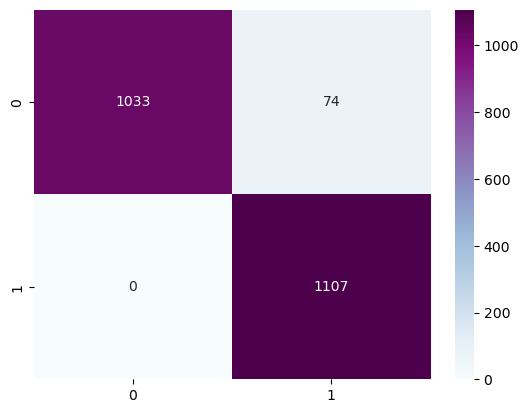

In [348]:
RFC_cm_us = confusion_matrix(y_train_us, RFC_y_pred_train_us)
sns.heatmap(RFC_cm_us, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the train set <b>

In [349]:
RFC_y_pred_test_us = RFC_grid_search_us.predict(x_test)
RFC_y_pred_test_us

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

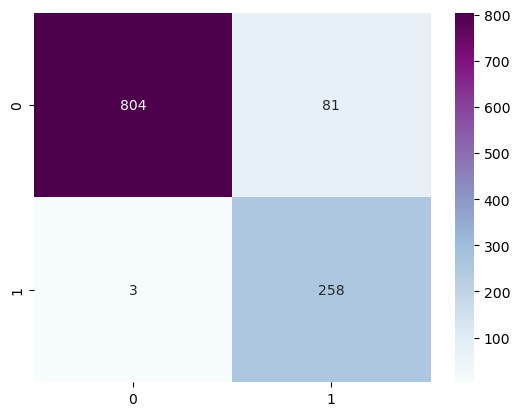

In [350]:
RFC_cm_us = confusion_matrix(y_test, RFC_y_pred_test_us)
sns.heatmap(RFC_cm_us, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the test set

In [351]:
RFC_roc_auc_score_us = roc_auc_score(y_test, RFC_y_pred_test_us)
RFC_roc_auc_score_us

0.9484901616988115

In [352]:
RFC_balanced_acc_score_us = balanced_accuracy_score(y_test, RFC_y_pred_test_us)
print(RFC_balanced_acc_score_us)

0.9484901616988116


In [353]:
RFC_class_report_imbalanced_us = classification_report_imbalanced(y_test, RFC_y_pred_test_us)
print(RFC_class_report_imbalanced_us)

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.91      0.99      0.95      0.95      0.89       885
          1       0.76      0.99      0.91      0.86      0.95      0.91       261

avg / total       0.94      0.93      0.97      0.93      0.95      0.89      1146



In [354]:
RFC_geometric_mean_us = geometric_mean_score(y_test, RFC_y_pred_test_us)
RFC_geometric_mean_us

0.9476456826062799

In [355]:
RFC_precision_score_us = precision_score(y_test, RFC_y_pred_test_us)
RFC_precision_score_us

0.7610619469026548

In [356]:
RFC_f1_score_us = f1_score(y_test, RFC_y_pred_test_us)
RFC_f1_score_us

0.86

In [357]:
RFC_recall_score_us = recall_score(y_test, RFC_y_pred_test_us)
RFC_recall_score_us

0.9885057471264368

<b> checking metrics scores for the Random ForestClassifier with UnderSampling method  

In [358]:
# Saving the model results into lists
model_list.append('Random Forest CLassifier(UnderSampled)')
roc_auc_score_list.append(round(roc_auc_score(y_test, RFC_y_pred_test_us), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, RFC_y_pred_test_us), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, RFC_y_pred_test_us), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, RFC_y_pred_test_us), 3))
f1_score_list.append(round(f1_score(y_test, RFC_y_pred_test_us), 3))
precision_score_list.append(round(precision_score(y_test, RFC_y_pred_test_us), 3))
recall_score_list.append(round(recall_score(y_test, RFC_y_pred_test_us), 3))

## Random Forest Classifier with OverSampling

In [359]:
RFC_os = RandomForestClassifier(n_estimators = 100,
                            random_state = 0,
                            n_jobs = -1,
                            max_features = 'sqrt',
                            criterion  = 'gini',
                            class_weight = 'balanced')

<b> training RFC model with OverSampling method 

In [360]:
RFC_param_grid_os = {
    'n_estimators': [100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 5, 8],
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1]
}

In [361]:
RFC_grid_search_os = GridSearchCV(estimator = RFC_os, 
                              param_grid = RFC_param_grid_os, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [362]:
%%timeit -r 1 -n 1

RFC_grid_search_os.fit(x_train_os, y_train_os)

2min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [363]:
RFC_grid_search_os.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'n_estimators': 100,
 'n_jobs': -1}

<b> checking for the best parameters with gridsearch best_params<b>

## Estimating Random Forest Classifier Oversampled

In [364]:
RFC_y_pred_train_os = RFC_grid_search_os.predict(x_train_os)
RFC_y_pred_train_os

array([0, 0, 1, ..., 1, 1, 1])

<AxesSubplot:>

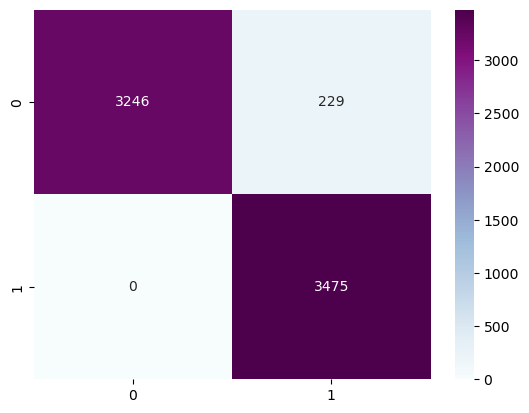

In [365]:
RFC_cm_os = confusion_matrix(y_train_os, RFC_y_pred_train_os)
sns.heatmap(RFC_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b>checking a heatmap of a confusion matrix for the train set

In [366]:
RFC_y_pred_test_os = RFC_grid_search_os.predict(x_test)
RFC_y_pred_test_os

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

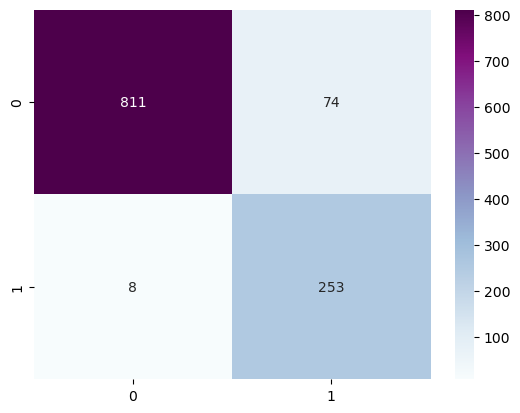

In [367]:
RFC_cm_os = confusion_matrix(y_test, RFC_y_pred_test_os)
sns.heatmap(RFC_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b>checking a heatmap of a confusion matrix for the test set

In [368]:
RFC_roc_auc_score_os = roc_auc_score(y_test, RFC_y_pred_test_os)
RFC_roc_auc_score_os

0.942866419897396

In [369]:
RFC_balanced_acc_score_os = balanced_accuracy_score(y_test, RFC_y_pred_test_os)
print(RFC_balanced_acc_score_os)

0.942866419897396


In [370]:
RFC_class_report_imbalanced_os = classification_report_imbalanced(y_test, RFC_y_pred_test_os)
print(RFC_class_report_imbalanced_os)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.92      0.97      0.95      0.94      0.88       885
          1       0.77      0.97      0.92      0.86      0.94      0.89       261

avg / total       0.94      0.93      0.96      0.93      0.94      0.89      1146



In [371]:
RFC_geometric_mean_os = geometric_mean_score(y_test, RFC_y_pred_test_os)
RFC_geometric_mean_os

0.9424944438998258

In [372]:
RFC_f1_score_os = f1_score(y_test, RFC_y_pred_test_os)
RFC_f1_score_os

0.8605442176870749

In [373]:
RFC_precision_score_os = precision_score(y_test, RFC_y_pred_test_os)
RFC_precision_score_os

0.7737003058103975

In [374]:
RFC_recall_score_os = recall_score(y_test, RFC_y_pred_test_os)
RFC_recall_score_os

0.9693486590038314

<b> checking metrics scores for the RFC with OverSampling method

In [375]:
# Save the model results into lists
model_list.append('Random Forest CLassifier(OverSampled)')
roc_auc_score_list.append(round(roc_auc_score(y_test, RFC_y_pred_test_os), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, RFC_y_pred_test_os), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, RFC_y_pred_test_os), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, RFC_y_pred_test_os), 3))
f1_score_list.append(round(f1_score(y_test, RFC_y_pred_test_os), 3))
precision_score_list.append(round(precision_score(y_test, RFC_y_pred_test_os), 3))
recall_score_list.append(round(recall_score(y_test, RFC_y_pred_test_os), 3))

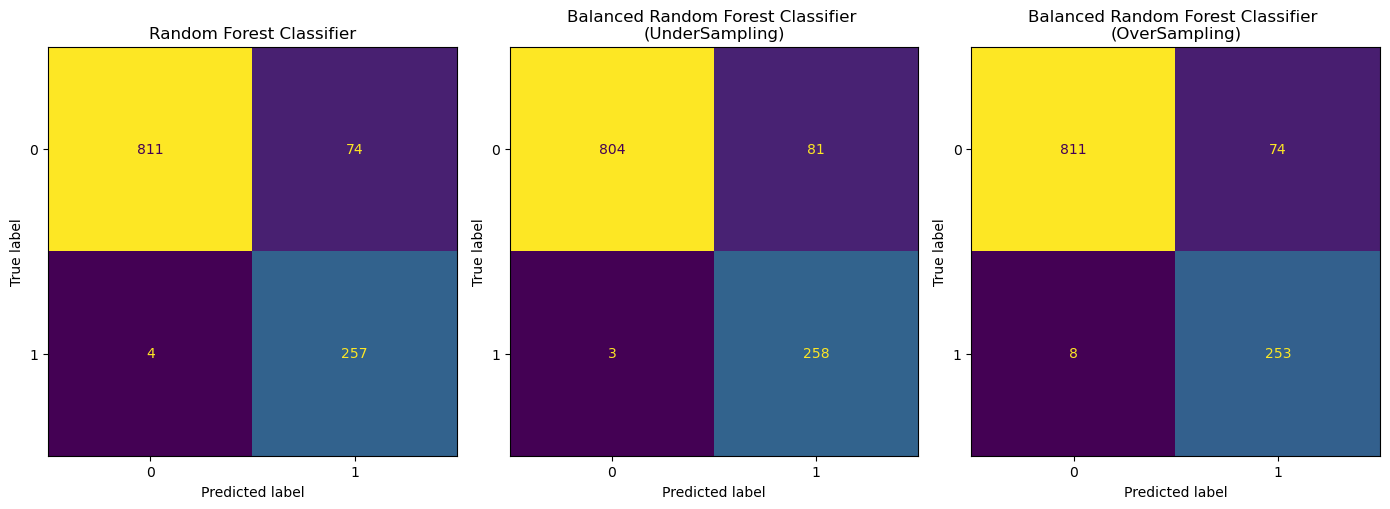

In [376]:
fig, axs = plt.subplots(ncols = 3, figsize = (14, 7))
plot_confusion_matrix(RFC_grid_search, x_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Random Forest Classifier")

plot_confusion_matrix(RFC_grid_search_us, x_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Random Forest Classifier \n(UnderSampling)")

plot_confusion_matrix(RFC_grid_search_os, x_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Random Forest Classifier \n(OverSampling)")

fig.tight_layout()

<b> creating a figure with three subplots, each showing a confusion matrix for a different version of a RandomForestClassifier

## SGD Classifier(Stochastic Gradient Decent)

In [377]:
SGD = SGDClassifier(penalty = 'l2',
                   n_jobs = -1,
                   class_weight = 'balanced')

<b> here SGD Classifier was chosen because it has parameter class_weight = 'balanced' <b>

In [378]:
SGD_param_grid = {
    'loss': ['log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'n_jobs': [-1],
    'random_state': [0],
    'class_weight': ['balanced']
}

In [379]:
SGD_grid_search = GridSearchCV(estimator = SGD, 
                              param_grid = SGD_param_grid, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [380]:
%%timeit -r 1 -n 1

SGD_grid_search.fit(x_train, y_train)

2.56 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [381]:
SGD_grid_search.best_params_

{'class_weight': 'balanced',
 'loss': 'log_loss',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 0}

<b> checking out for the best parameters with GridSearchCV best_params

## SGDClassification Estimating(Stochastic Gradient Decent)

In [382]:
SGD_y_pred_train = SGD_grid_search.predict(x_train)
SGD_y_pred_train

array([0, 0, 1, ..., 0, 0, 0])

<AxesSubplot:>

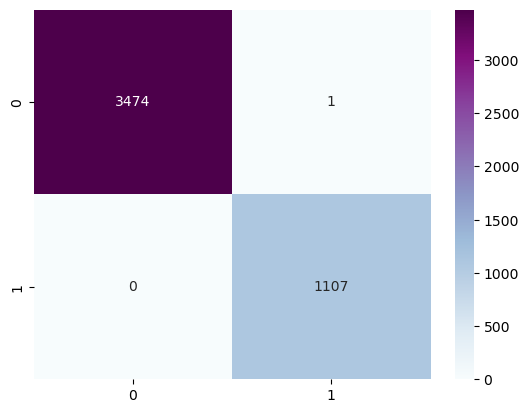

In [383]:
SGD_cm = confusion_matrix(y_train, SGD_y_pred_train)
sns.heatmap(SGD_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b>checking a heatmap of a confusion matrix for the train set

In [384]:
SGD_y_pred_test = SGD_grid_search.predict(x_test)
SGD_y_pred_test

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

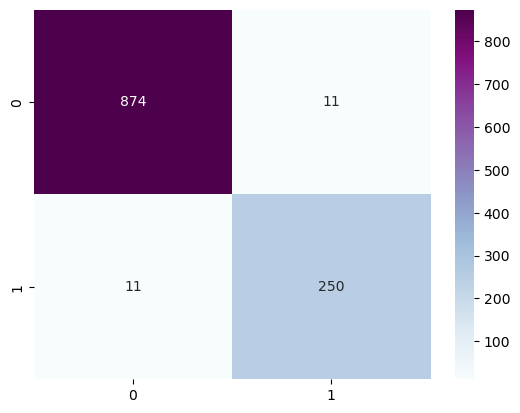

In [385]:
SGD_cm = confusion_matrix(y_test, SGD_y_pred_test)
sns.heatmap(SGD_cm, annot =True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the test set

In [386]:
SGD_roc_auc_score = roc_auc_score(y_test, SGD_y_pred_test)
SGD_roc_auc_score

0.9727125137995974

In [387]:
SGD_classification_report = classification_report_imbalanced(y_test, SGD_y_pred_test)
                                                      
print(SGD_classification_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.96      0.99      0.97      0.95       885
          1       0.96      0.96      0.99      0.96      0.97      0.94       261

avg / total       0.98      0.98      0.96      0.98      0.97      0.95      1146



In [388]:
SGD_geometric_mean = geometric_mean_score(y_test, SGD_y_pred_test)
SGD_geometric_mean

0.9725990289625106

In [389]:
SGD_precision_score = precision_score(y_test, SGD_y_pred_test)
SGD_precision_score

0.9578544061302682

In [390]:
SGD_f1_score = f1_score(y_test, SGD_y_pred_test)
SGD_f1_score

0.9578544061302682

In [391]:
SGD_recall_score = recall_score(y_test, SGD_y_pred_test)
SGD_recall_score

0.9578544061302682

<b> checking metrics scores for the SGD

In [392]:
# Saving the model results into lists
model_list.append('SGD(Stochastic Gradient Decent)')
roc_auc_score_list.append(round(roc_auc_score(y_test, SGD_y_pred_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, SGD_y_pred_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, SGD_y_pred_test), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, SGD_y_pred_test), 3))
f1_score_list.append(round(f1_score(y_test, SGD_y_pred_test), 3))
precision_score_list.append(round(precision_score(y_test, SGD_y_pred_test), 3))
recall_score_list.append(round(recall_score(y_test, SGD_y_pred_test), 3))

## SGD(Stochastic Gradient Decent with UnderSampling)

In [393]:
SGD_us = SGDClassifier(penalty = 'l2',
                   n_jobs = -1,
                   class_weight = 'balanced')

<b> training SGD with UnderSampling method

In [394]:
SGD_param_grid_us = {
    'loss': ['log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'n_jobs': [-1],
    'random_state': [0],
    'class_weight': ['balanced']
}

In [395]:
SGD_grid_search_us = GridSearchCV(estimator = SGD_us, 
                              param_grid = SGD_param_grid_us, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [396]:
%%timeit -r 1 -n 1

SGD_grid_search_us.fit(x_train_us, y_train_us)

639 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [397]:
SGD_grid_search_us.best_params_

{'class_weight': 'balanced',
 'loss': 'log_loss',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 0}

<b> checking for best suited parameters with GridSearchCV best_params

## Estimating SGD UnderSampled

In [398]:
SGD_y_pred_train_us = SGD_grid_search_us.predict(x_train_us)
SGD_y_pred_train_us

array([0, 0, 0, ..., 1, 1, 1])

<AxesSubplot:>

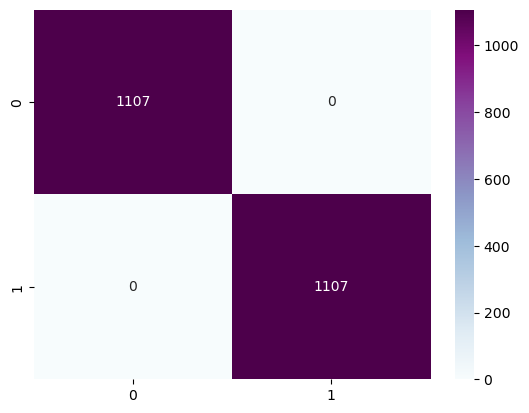

In [399]:
SGD_cm_us = confusion_matrix(y_train_us, SGD_y_pred_train_us)
sns.heatmap(SGD_cm_us, annot = True, fmt = 'd', cmap = 'BuPu')

<b>checking a heatmap of a confusion matrix for the train set

In [400]:
SGD_y_pred_test_us = SGD_grid_search_us.predict(x_test)
SGD_y_pred_test_us

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

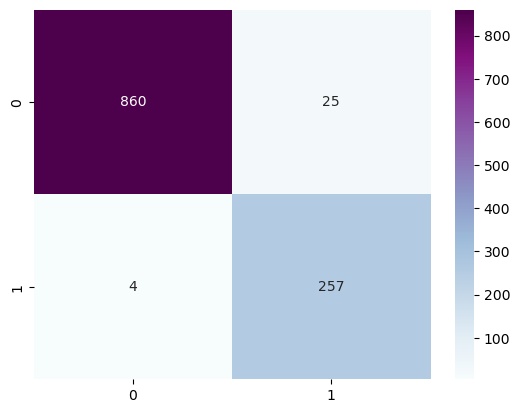

In [401]:
SGD_cm_us = confusion_matrix(y_test, SGD_y_pred_test_us)
sns.heatmap(SGD_cm_us, annot = True, fmt = 'd', cmap = 'BuPu')

<b>checking a heatmap of a confusion matrix for the test set

In [402]:
SGD_roc_auc_score_us = roc_auc_score(y_test, SGD_y_pred_test_us)
SGD_roc_auc_score_us

0.9782128709656471

In [403]:
SGD_balanced_acc_score_us = balanced_accuracy_score(y_test, SGD_y_pred_test_us)
print(SGD_balanced_acc_score_us)

0.9782128709656471


In [404]:
SGD_class_report_imbalanced = classification_report_imbalanced(y_test, SGD_y_pred_test_us)
print(SGD_class_report_imbalanced)

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.98      0.98      0.98      0.96       885
          1       0.91      0.98      0.97      0.95      0.98      0.96       261

avg / total       0.98      0.97      0.98      0.98      0.98      0.96      1146



In [405]:
SGD_geometric_mean_us = geometric_mean_score(y_test, SGD_y_pred_test_us)
SGD_geometric_mean_us

0.9781915305687521

In [406]:
SGD_precision_score_us = precision_score(y_test, SGD_y_pred_test_us)
SGD_precision_score_us

0.9113475177304965

In [407]:
SGD_f1_score_us = f1_score(y_test, SGD_y_pred_test_us)
SGD_f1_score_us

0.9465930018416207

In [408]:
SGD_recall_score_us = recall_score(y_test, SGD_y_pred_test_us)
SGD_recall_score_us

0.9846743295019157

<b> checking metrics scores for SGD with undersampling method

In [409]:
# Save the model results into lists
model_list.append('SGD(Stochastic Gradient Decent) UnderSampled')
roc_auc_score_list.append(round(roc_auc_score(y_test, SGD_y_pred_test_us), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, SGD_y_pred_test_us), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, SGD_y_pred_test_us), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, SGD_y_pred_test_us), 3))
f1_score_list.append(round(f1_score(y_test, SGD_y_pred_test_us), 3))
precision_score_list.append(round(precision_score(y_test, SGD_y_pred_test_us), 3))
recall_score_list.append(round(recall_score(y_test, SGD_y_pred_test_us), 3))

## SGD with OverSampling

In [410]:
SGD_os = SGDClassifier(penalty = 'l2',
                   n_jobs = -1,
                   class_weight = 'balanced')

<b> training SGD with OverSampling method

In [411]:
SGD_param_grid_os = {
    'loss': ['log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'n_jobs': [-1],
    'random_state': [0],
    'class_weight': ['balanced']
}

In [412]:
SGD_grid_search_os = GridSearchCV(estimator = SGD_os, 
                              param_grid = SGD_param_grid_os, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [413]:
%%timeit -r 1 -n 1

SGD_grid_search_os.fit(x_train_os, y_train_os)

3.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [414]:
SGD_grid_search_os.best_params_

{'class_weight': 'balanced',
 'loss': 'log_loss',
 'n_jobs': -1,
 'penalty': 'elasticnet',
 'random_state': 0}

## Estimating SGD OverSampled

In [415]:
SGD_y_pred_train_os = SGD_grid_search_os.predict(x_train_os)
SGD_y_pred_train_os

array([0, 0, 1, ..., 1, 1, 1])

<AxesSubplot:>

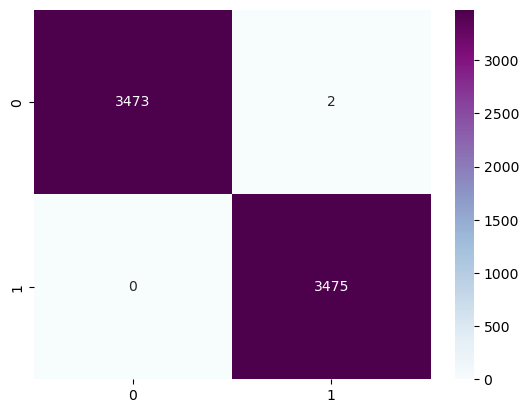

In [416]:
SGD_cm_os = confusion_matrix(y_train_os, SGD_y_pred_train_os)
sns.heatmap(SGD_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b>checking a heatmap of a confusion matrix for the train set

In [417]:
SGD_y_pred_test_os = SGD_grid_search_os.predict(x_test)
SGD_y_pred_test_os

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

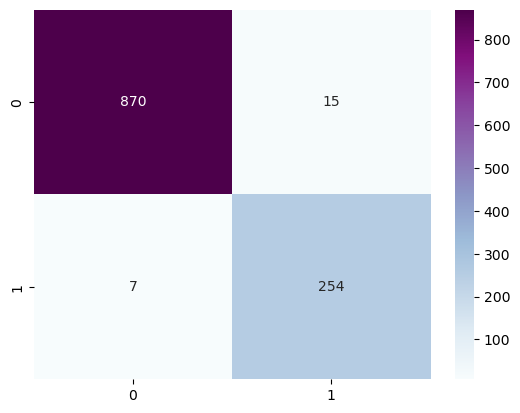

In [418]:
SGD_cm_os = confusion_matrix(y_test, SGD_y_pred_test_os)
sns.heatmap(SGD_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b>checking a heatmap of a confusion matrix for the test set

In [419]:
SGD_roc_auc_score_os = roc_auc_score(y_test, SGD_y_pred_test_os)
SGD_roc_auc_score_os

0.9781154620429898

In [420]:
SGD_balanced_acc_score_os = balanced_accuracy_score(y_test, SGD_y_pred_test_os)
print(SGD_balanced_acc_score_os)

0.9781154620429898


In [421]:
SGD_class_report_imbalanced_os = classification_report_imbalanced(y_test, SGD_y_pred_test_os)
print(SGD_class_report_imbalanced_os)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.98      0.97      0.99      0.98      0.96       885
          1       0.94      0.97      0.98      0.96      0.98      0.96       261

avg / total       0.98      0.98      0.98      0.98      0.98      0.96      1146



In [422]:
SGD_geometric_mean_os = geometric_mean_score(y_test, SGD_y_pred_test_os)
SGD_geometric_mean_os

0.9781030104535925

In [423]:
SGD_precision_score_os = precision_score(y_test, SGD_y_pred_test_os)
SGD_precision_score_os

0.9442379182156134

In [424]:
SGD_f1_score_os = f1_score(y_test, SGD_y_pred_test_os)
SGD_f1_score_os

0.958490566037736

In [425]:
SGD_recall_score_os = recall_score(y_test, SGD_y_pred_test_os)
SGD_recall_score_os

0.9731800766283525

<b>checking metrics scores for the SGD with OverSampling method
   

In [426]:
# Save the model results into lists
model_list.append('SGD(Stochastic Gradient Decent) OverSampled')
roc_auc_score_list.append(round(roc_auc_score(y_test, SGD_y_pred_test_os), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, SGD_y_pred_test_os), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, SGD_y_pred_test_os), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, SGD_y_pred_test_os), 3))
f1_score_list.append(round(f1_score(y_test, SGD_y_pred_test_os), 3))
precision_score_list.append(round(precision_score(y_test, SGD_y_pred_test_os), 3))
recall_score_list.append(round(recall_score(y_test, SGD_y_pred_test_os), 3))

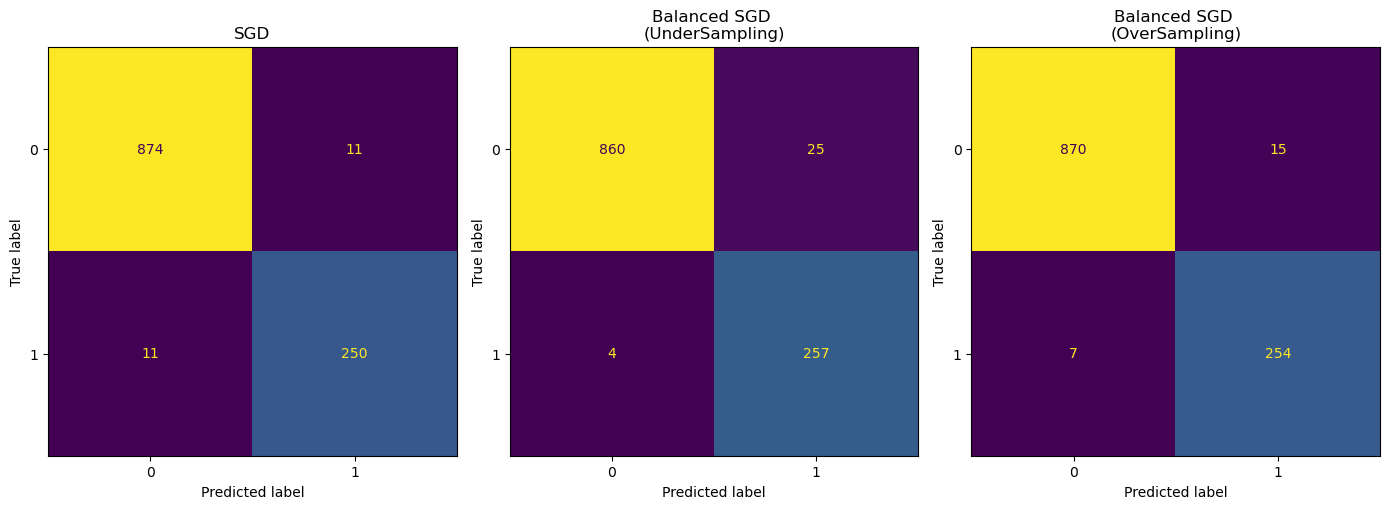

In [427]:
fig, axs = plt.subplots(ncols = 3, figsize = (14, 7))
plot_confusion_matrix(SGD_grid_search, x_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("SGD")

plot_confusion_matrix(SGD_grid_search_us, x_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced SGD \n(UnderSampling)")

plot_confusion_matrix(SGD_grid_search_os, x_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced SGD \n(OverSampling)")

fig.tight_layout()

<b> creating and checking figure with three subplots, each showing confusion matrix for  different versions of a SGD

## SVC(Support Vector Classifier)

In [428]:
svc = SVC(kernel = 'rbf',
         max_iter = -1,
         C = 1.0,
         class_weight = 'balanced')

<b> training SVC model with parameter class_weight = 'balanced' 

In [429]:
svc_param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced'],
    'max_iter': [-1],
    'gamma': ['scale', 'auto']
}

In [430]:
svc_grid_search = GridSearchCV(estimator = svc, 
                              param_grid = svc_param_grid, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [431]:
%%timeit -r 1 -n 1

svc_grid_search.fit(x_train, y_train)

1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [432]:
svc_grid_search.best_params_

{'class_weight': 'balanced',
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1}

<b> checking for the best parameters with the help of GridSearchCV best_params

## SVC Estimating

In [433]:
svc_y_pred_train = svc_grid_search.predict(x_train)
svc_y_pred_train

array([0, 0, 1, ..., 0, 0, 0])

<AxesSubplot:>

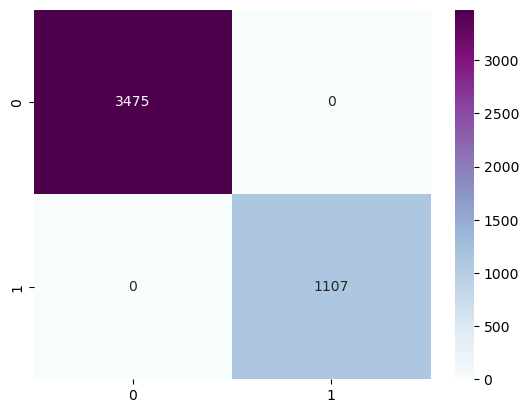

In [434]:
svc_cm = confusion_matrix(y_train, svc_y_pred_train)
sns.heatmap(svc_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the train set

In [435]:
svc_y_pred_test = svc_grid_search.predict(x_test)
svc_y_pred_test

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

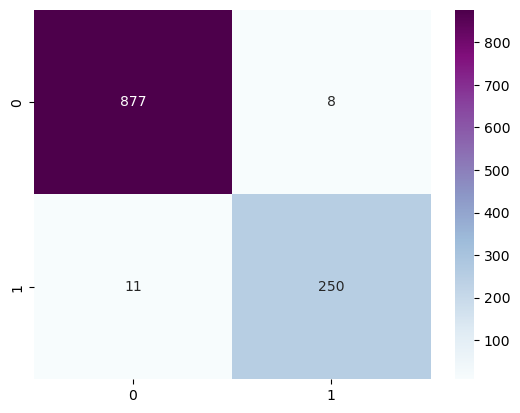

In [436]:
svc_cm = confusion_matrix(y_test, svc_y_pred_test)
sns.heatmap(svc_cm, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the test set

In [437]:
svc_roc_auc_score = roc_auc_score(y_test, svc_y_pred_test)
svc_roc_auc_score

0.9744074290538347

In [438]:
svc_classification_report = classification_report_imbalanced(y_test, svc_y_pred_test)
                                                      
print(svc_classification_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.96      0.99      0.97      0.95       885
          1       0.97      0.96      0.99      0.96      0.97      0.95       261

avg / total       0.98      0.98      0.97      0.98      0.97      0.95      1146



In [439]:
svc_geometric_mean = geometric_mean_score(y_test, svc_y_pred_test)
svc_geometric_mean

0.9742668193197362

In [440]:
svc_f1_score = f1_score(y_test, svc_y_pred_test)
svc_f1_score

0.9633911368015413

In [441]:
svc_precision_score = precision_score(y_test, svc_y_pred_test)
svc_precision_score

0.9689922480620154

In [442]:
svc_recall_score = recall_score(y_test, svc_y_pred_test)
svc_recall_score

0.9578544061302682

<b> checking metrics scores for the SVC

In [443]:
# Saving the model results into lists
model_list.append('SVC(Support Vector Classifier)')
roc_auc_score_list.append(round(roc_auc_score(y_test, svc_y_pred_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, svc_y_pred_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, svc_y_pred_test), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, svc_y_pred_test), 3))
f1_score_list.append(round(f1_score(y_test, svc_y_pred_test), 3))
precision_score_list.append(round(precision_score(y_test, svc_y_pred_test), 3))
recall_score_list.append(round(recall_score(y_test, svc_y_pred_test), 3))

## SVC(Support Vector Classifier) with UnderSampling

In [444]:
svc_us = SVC(kernel = 'rbf',
         max_iter = -1,
         C = 1.0,
         class_weight = 'balanced')

<b> training SVC with UnderSampling method

In [445]:
svc_param_grid_us = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced'],
    'max_iter': [-1],
    'gamma': ['scale', 'auto']
}

In [446]:
svc_grid_search_us = GridSearchCV(estimator = svc_us, 
                              param_grid = svc_param_grid_us, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [447]:
%%timeit -r 1 -n 1

svc_grid_search_us.fit(x_train_us, y_train_us)

15.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [448]:
svc_grid_search_us.best_params_

{'class_weight': 'balanced',
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1}

<b> checking for the best parameters with the help of GridSearchCV best_params

## Estimating SVC UnderSampled

In [449]:
svc_y_pred_train_us = svc_grid_search_us.predict(x_train_us)
svc_y_pred_train_us

array([0, 0, 0, ..., 1, 1, 1])

<AxesSubplot:>

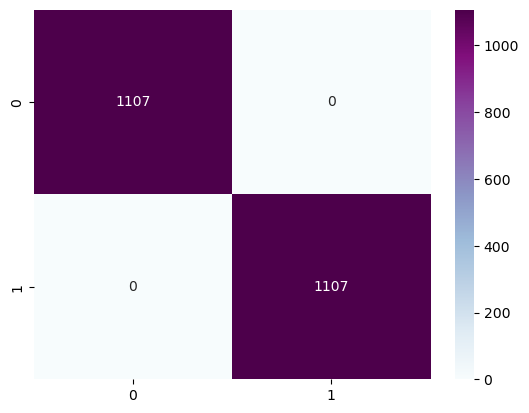

In [450]:
svc_cm_us = confusion_matrix(y_train_us, svc_y_pred_train_us)
sns.heatmap(svc_cm_us, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the train set

In [451]:
svc_y_pred_test_us = svc_grid_search_us.predict(x_test)
svc_y_pred_test_us

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

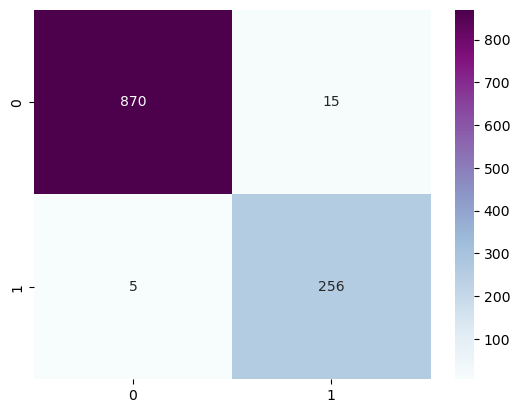

In [452]:
svc_cm_us = confusion_matrix(y_test, svc_y_pred_test_us)
sns.heatmap(svc_cm_us, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the test set

In [453]:
svc_roc_auc_score_us = roc_auc_score(y_test, svc_y_pred_test_us)
svc_roc_auc_score_us

0.9819468796675108

In [454]:
svc_classification_report_us = classification_report_imbalanced(y_test, svc_y_pred_test_us)
                                                      
print(svc_classification_report_us)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.98      0.98      0.99      0.98      0.96       885
          1       0.94      0.98      0.98      0.96      0.98      0.96       261

avg / total       0.98      0.98      0.98      0.98      0.98      0.96      1146



In [455]:
svc_balanced_class_report_us = balanced_accuracy_score(y_test, svc_y_pred_test_us)
svc_balanced_class_report_us

0.9819468796675108

In [456]:
svc_f1_score = f1_score(y_test, svc_y_pred_test_us)
svc_f1_score

0.9624060150375939

In [457]:
svc_precision_score = precision_score(y_test, svc_y_pred_test_us)
svc_precision_score

0.9446494464944649

In [458]:
svc_recall_score = recall_score(y_test, svc_y_pred_test_us)
svc_recall_score

0.9808429118773946

In [459]:
svc_geometric_mean = geometric_mean_score(y_test, svc_y_pred_test_us)
svc_geometric_mean

0.9819462590915449

<b> metrics scores for the SVC with UnderSampling method
    

In [460]:
# Saving the model results into lists
model_list.append('SVC(Support Vector Classifier) UnderSampled')
roc_auc_score_list.append(round(roc_auc_score(y_test, svc_y_pred_test_us), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, svc_y_pred_test_us), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, svc_y_pred_test_us), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, svc_y_pred_test_us), 3))
f1_score_list.append(round(f1_score(y_test, svc_y_pred_test_us), 3))
precision_score_list.append(round(precision_score(y_test, svc_y_pred_test_us), 3))
recall_score_list.append(round(recall_score(y_test, svc_y_pred_test_us), 3))

## SVC (Support Vector Classifier) with OverSampling

In [461]:
svc_os = SVC(kernel = 'rbf',
         max_iter = -1,
         C = 1.0,
         class_weight = 'balanced')

 <b> training SVC with OverSampling method

In [462]:
svc_param_grid_os = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced'],
    'max_iter': [-1],
    'gamma': ['scale', 'auto']
}

In [463]:
svc_grid_search_os = GridSearchCV(estimator = svc_os, 
                              param_grid = svc_param_grid_os, 
                              cv = 6, n_jobs = -1, scoring = 'accuracy')

In [464]:
%%timeit -r 1 -n 1

svc_grid_search_os.fit(x_train_os, y_train_os)

2min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [465]:
svc_grid_search_os.best_params_

{'class_weight': 'balanced',
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1}

<b> checking for the best parameters with GridSearchCV best_params

## Estimating SVC OverSampled

In [466]:
svc_y_pred_train_os = svc_grid_search_os.predict(x_train_os)
svc_y_pred_train_os

array([0, 0, 1, ..., 1, 1, 1])

<AxesSubplot:>

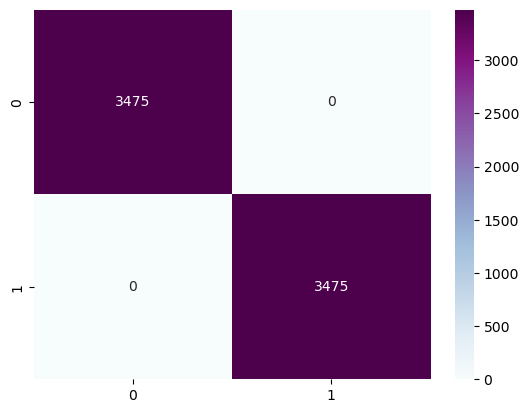

In [467]:
svc_cm_os = confusion_matrix(y_train_os, svc_y_pred_train_os)
sns.heatmap(svc_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the train set

In [468]:
svc_y_pred_test_os = svc_grid_search_os.predict(x_test)
svc_y_pred_test_os

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

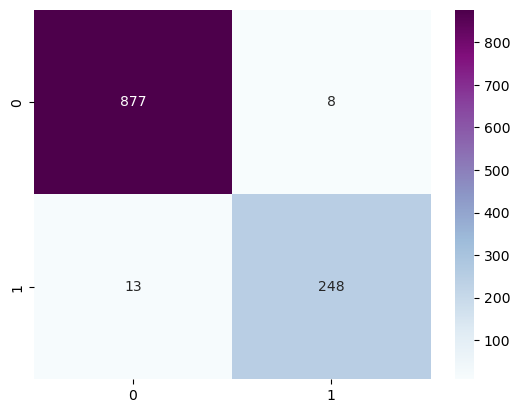

In [469]:
svc_cm_os = confusion_matrix(y_test, svc_y_pred_test_os)
sns.heatmap(svc_cm_os, annot = True, fmt = 'd', cmap = 'BuPu')

<b> checking a heatmap of a confusion matrix for the test set

In [470]:
svc_roc_auc_score_os = roc_auc_score(y_test, svc_y_pred_test_os)
svc_roc_auc_score_os

0.9705760114293136

In [471]:
svc_classification_report_os = classification_report_imbalanced(y_test, svc_y_pred_test_os)
                                                      
print(svc_classification_report_os)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.95      0.99      0.97      0.95       885
          1       0.97      0.95      0.99      0.96      0.97      0.94       261

avg / total       0.98      0.98      0.96      0.98      0.97      0.94      1146



In [472]:
svc_balanced_class_report_os = balanced_accuracy_score(y_test, svc_y_pred_test_os)
svc_balanced_class_report_os

0.9705760114293136

In [473]:
svc_f1_score_os = f1_score(y_test, svc_y_pred_test_os)
svc_f1_score_os

0.9593810444874274

In [474]:
svc_precision_score = precision_score(y_test, svc_y_pred_test_os)
svc_precision_score

0.96875

In [475]:
svc_recall_score = recall_score(y_test, svc_y_pred_test_os)
svc_recall_score

0.9501915708812261

In [476]:
svc_geometric_mean = geometric_mean_score(y_test, svc_y_pred_test_os)
svc_geometric_mean

0.9703619265746037

<b> metrics scores are good showing high results

In [477]:
# Save the model results into lists
model_list.append('SVC(Support Vector Classifier) OverSampled')
roc_auc_score_list.append(round(roc_auc_score(y_test, svc_y_pred_test_os), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, svc_y_pred_test_os), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, svc_y_pred_test_os), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, svc_y_pred_test_os), 3))
f1_score_list.append(round(f1_score(y_test, svc_y_pred_test_os), 3))
precision_score_list.append(round(precision_score(y_test, svc_y_pred_test_os), 3))
recall_score_list.append(round(recall_score(y_test, svc_y_pred_test_os), 3))

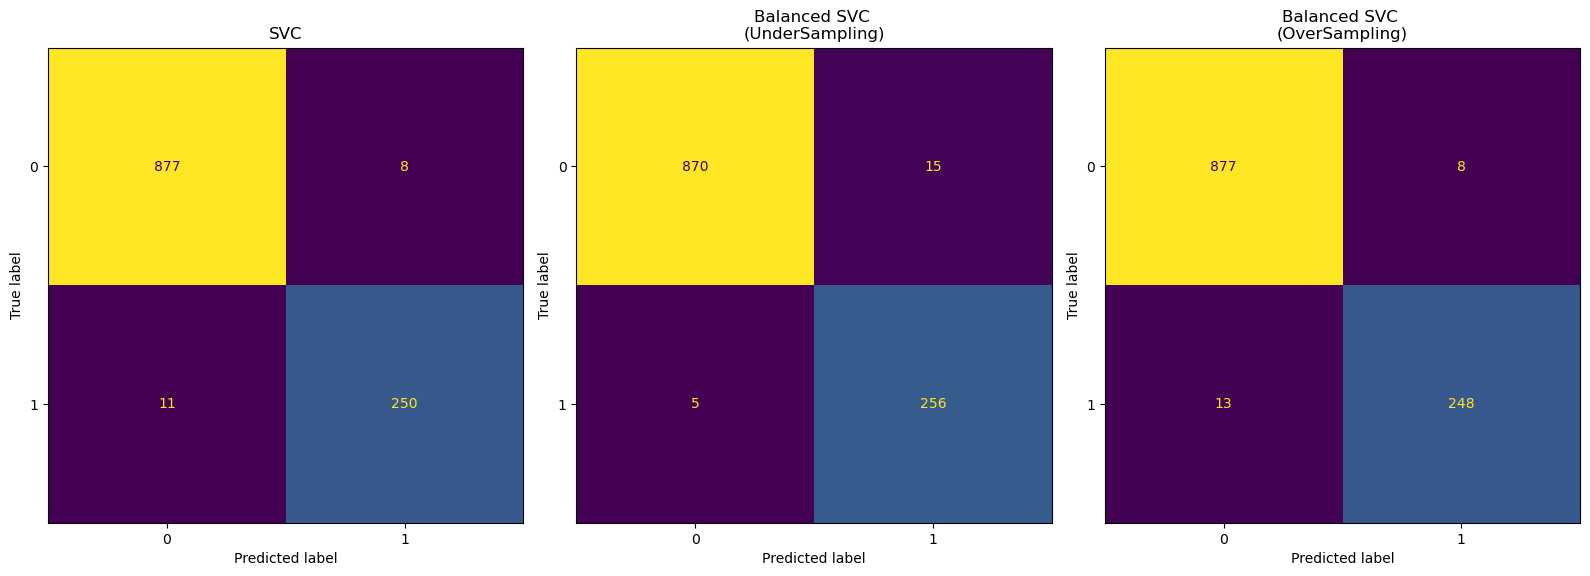

In [478]:
fig, axs = plt.subplots(ncols = 3, figsize = (16, 8))
plot_confusion_matrix(svc_grid_search, x_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("SVC")

plot_confusion_matrix(svc_grid_search_us, x_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced SVC \n(UnderSampling)")

plot_confusion_matrix(svc_grid_search_os, x_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced SVC \n(OverSampling)")

fig.tight_layout()

<b> creating and checking a figure with three subplots, each showing a confusion matrix for a different version of a SVC.

## Voting Classifier

In [479]:
models = []

models.append(('Log_Reg', LogisticRegression(random_state = 0, 
                                             class_weight = 'balanced', 
                                             C = 0.01)))

models.append(('DTC', DecisionTreeClassifier(random_state = 0,  
                                            max_depth = 5,
                                            criterion = 'gini',
                                            min_samples_split = 2,
                                            class_weight = 'balanced')))

models.append(('RFC', RandomForestClassifier(n_estimators = 100,
                                            random_state = 0,
                                            
                                            max_features = 'sqrt',
                                            criterion  ='gini',
                                            class_weight = 'balanced')))

models.append(('SGD', SGDClassifier(penalty = 'l2',
                                   n_jobs = -1,
                                   class_weight = 'balanced')))
              
models.append(('SVC', SVC(kernel = 'rbf',
                max_iter = -1,
                C = 1.0,
                class_weight = 'balanced')))


 <b> creating a list of different classification models to be used for Voting Classifier. <b>

In [480]:
ensemble = VotingClassifier(estimators = models, voting = 'hard')

In [481]:
%%timeit -r 1 -n 1
ensemble.fit(x_train, y_train)

7.71 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<b> Training model with Voting Classifier <b>

In [482]:
'''
Checking out the scores
'''


print("{} score train set:{}".format('Voting Classifier', ensemble.score(x_train, y_train)))
print("{} score test set:{}".format('Voting Classifier', ensemble.score(x_test, y_test)))

Voting Classifier score train set:0.9853775643823658
Voting Classifier score test set:0.962478184991274


In [483]:
'''
Using an ensemble model to make predictions on the training set.
'''

voting_y_pred_train = ensemble.predict(x_train)
voting_y_pred_train

array([0, 0, 1, ..., 0, 0, 0])

<AxesSubplot:>

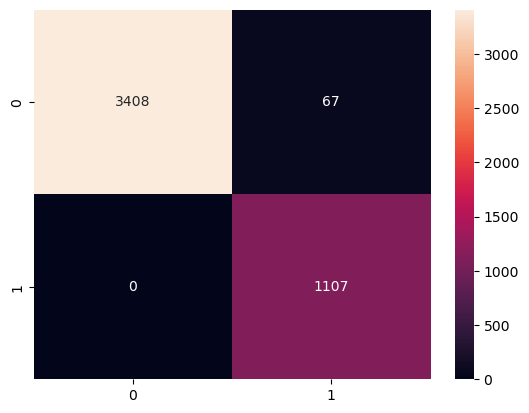

In [484]:
'''
Using the predicted output values generated by the ensemble model and the actual 
output values from the training set to create a confusion matrix.
'''

voting_cm = confusion_matrix(y_train, voting_y_pred_train)
sns.heatmap(voting_cm, annot = True, fmt = 'd')

<b> checking a heatmap of a confusion matrix for the train set

In [485]:
'''
Using an ensemble model to make predictions on the test set.
'''

voting_y_pred_test = ensemble.predict(x_test)
voting_y_pred_test

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:>

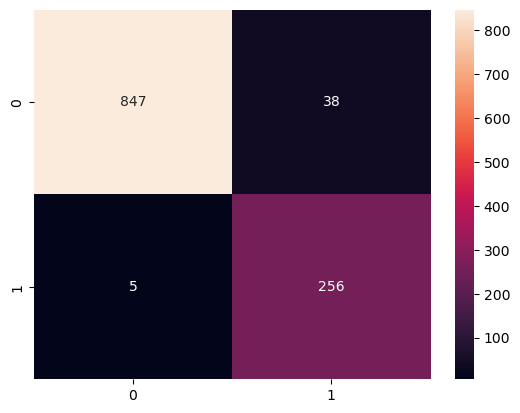

In [486]:
'''
Using the predicted output values generated by the ensemble model and the actual 
output values from the test set to create a confusion matrix.
'''

voting_cm = confusion_matrix(y_test, voting_y_pred_test)
sns.heatmap(voting_cm, annot = True, fmt = 'd')

<b> checking a heatmap of a confusion matrix for the test set

In [487]:
'''
Calculating roc auc score for the ensemble model on the test set.
'''

voting_roc_auc_score = roc_auc_score(y_test, voting_y_pred_test)
voting_roc_auc_score

0.9689525293850249

In [488]:
'''
 Using the predicted output values generated by the ensemble model and the actual output values from the test set to create a classification report 
 that includes metrics such as precision, recall, and F1 score.
'''

voting_classification_report = classification_report_imbalanced(y_test, voting_y_pred_test)
                                                      
print(voting_classification_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.96      0.98      0.98      0.97      0.94       885
          1       0.87      0.98      0.96      0.92      0.97      0.94       261

avg / total       0.97      0.96      0.98      0.96      0.97      0.94      1146



In [489]:
'''
calculating the F1 score for the ensemble model on the test set.
'''

voting_f1_score = f1_score(y_test, voting_y_pred_test)
voting_f1_score

0.9225225225225224

In [490]:
'''
calculating the precision score for the ensemble model on the test set.
'''

voting_precision_score = precision_score(y_test, voting_y_pred_test)
voting_precision_score

0.8707482993197279

In [491]:
'''
calculating the geometric mean score for the ensemble model on the test set.
'''

voting_geometric_mean = geometric_mean_score(y_test, voting_y_pred_test)
voting_geometric_mean

0.9688795709508086

In [492]:
'''
calculating the recall score for the ensemble model on the test set.
'''
voting_recall_score = recall_score(y_test, voting_y_pred_test)
voting_recall_score

0.9808429118773946

In [493]:
# Save the model results into lists
model_list.append('Voting Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, voting_y_pred_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, voting_y_pred_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, voting_y_pred_test), 3))
classification_report_imbalanced_list.append((classification_report_imbalanced(y_test, voting_y_pred_test), 3))
f1_score_list.append(round(f1_score(y_test, voting_y_pred_test), 3))
precision_score_list.append(round(precision_score(y_test, voting_y_pred_test), 3))
recall_score_list.append(round(recall_score(y_test, voting_y_pred_test), 3))

## Evaluating The Models

In [494]:
'''
creating a Pandas DataFrame called model_results 
to store the evaluation metrics for each of the models in model_list.
'''
model_results = pd.DataFrame({'Model': model_list, 
                             'roc_auc_score': roc_auc_score_list, 
                             'balanced_accuracy_score': balanced_accuracy_list, 
                             'geometric_mean_score': geometric_mean_list, 
                             'f1_score': f1_score_list})      
model_results

,Model,roc_auc_score,balanced_accuracy_score,geometric_mean_score,f1_score
0,Logistic Regression (Imbalanced),0.915,0.915,0.913,0.789
1,Logistic Regression (OverSampling),0.977,0.977,0.977,0.951
2,Logistic Regression (undersampling),0.970,0.970,0.970,0.926
3,Random Forest CLassifier,0.951,0.951,0.950,0.868
4,Random Forest CLassifier(UnderSampled),0.948,0.948,0.948,0.860
5,Random Forest CLassifier(OverSampled),0.943,0.943,0.942,0.861
6,SGD(Stochastic Gradient Decent),0.973,0.973,0.973,0.958
7,SGD(Stochastic Gradient Decent) UnderSampled,0.978,0.978,0.978,0.947
8,SGD(Stochastic Gradient Decent) OverSampled,0.978,0.978,0.978,0.958
9,SVC(Support Vector Classifier),0.974,0.974,0.974,0.963


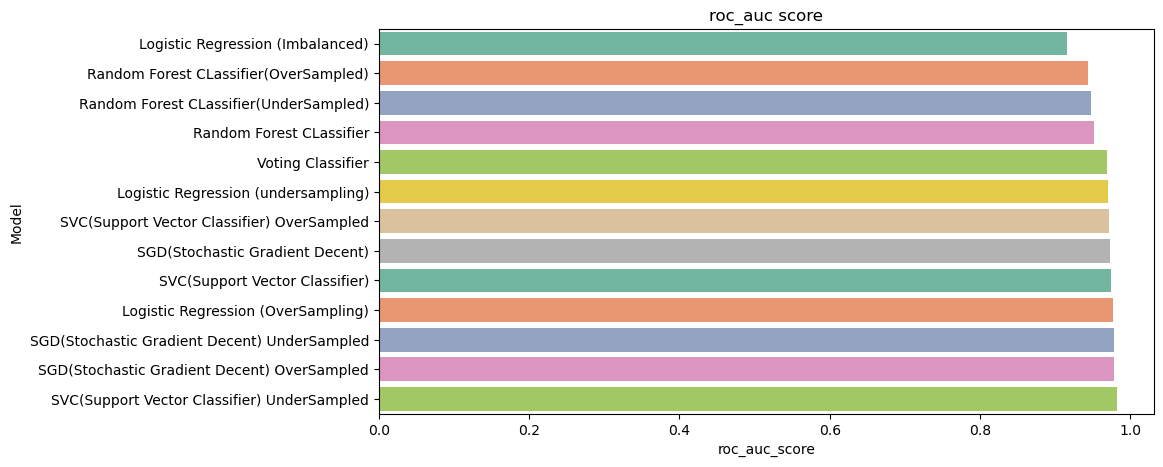

In [495]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='roc_auc_score', ascending = True), 
            x = 'roc_auc_score', y = 'Model', palette = 'Set2')
plt.title("roc_auc score")
plt.show()

<b> Creating a bar chart showing the roc_auc_score for each model in the model_results DataFrame. The bars are sorted from lowest to highest roc_auc_score.

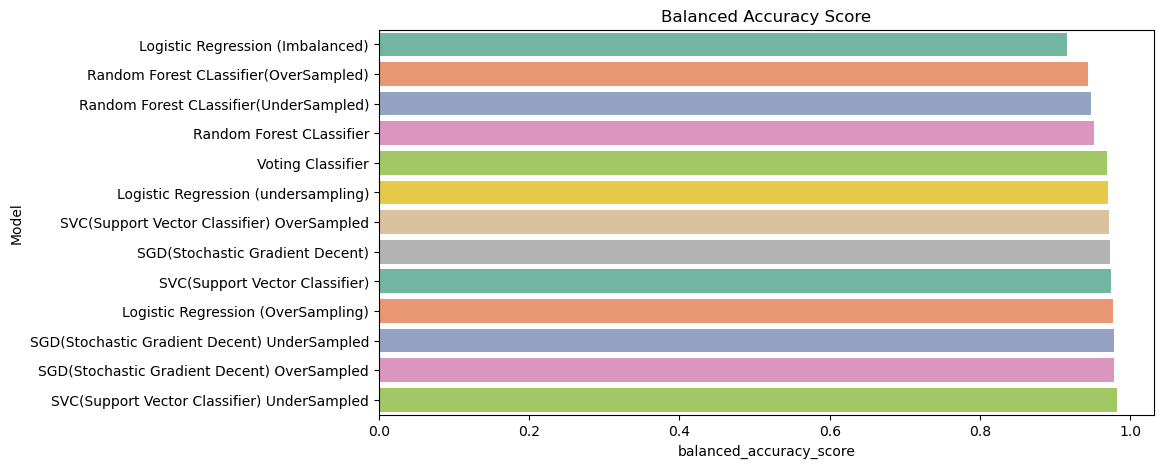

In [496]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='balanced_accuracy_score', ascending = True), 
            x = 'balanced_accuracy_score', y = 'Model', palette = 'Set2')
plt.title("Balanced Accuracy Score")
plt.show()

<b> Creating a bar chart showing the balanced_accuracy_score for each model in the model_results DataFrame. The bars are sorted from lowest to highest balanced_accuracy_score

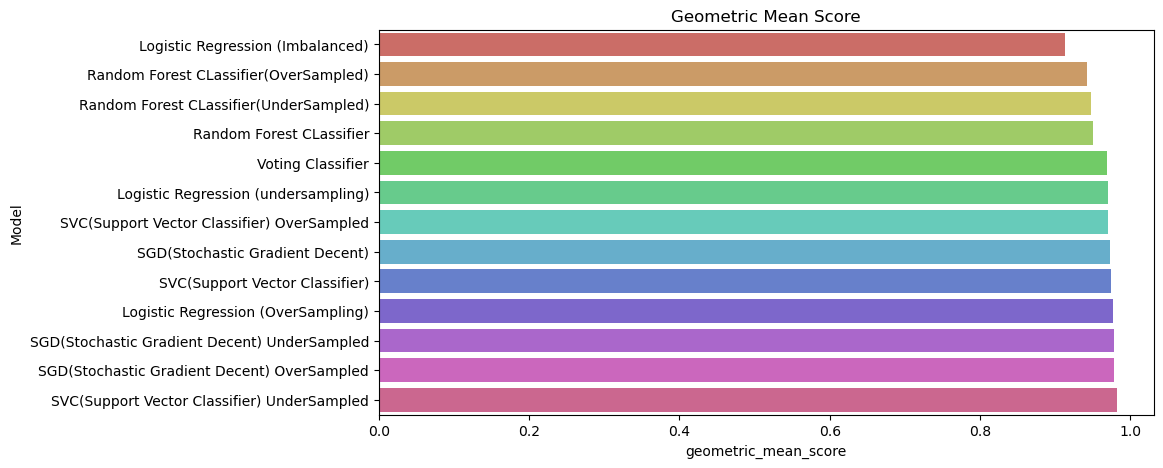

In [497]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='geometric_mean_score', ascending = True), 
            x = 'geometric_mean_score', y = 'Model', palette = 'hls')
plt.title("Geometric Mean Score")
plt.show()

<b> Creating a bar chart showing the geometric_mean_score for each model in the model_results DataFrame. The bars are sorted from lowest to highest geometric_mean_score

## Testing Review

In [500]:
test_sample = [input('Email: ')]
ts_countvectorizer = vectorizer.transform(test_sample)

Email: Subject: security alert - confirm your national credit union information  - - > 


In [501]:
test_review = pd.DataFrame(ts_countvectorizer.toarray())

test_predict = ensemble.predict(test_review)

test_predict

if test_predict == 1:
    print('Spammed e-mail')
else:
    print('Not Spammed e-mail')

Spammed e-mail


<b>Testing out model if it can predict the result correctly with ensemble method
   <b>

## Conclusion

1. As e-mails is a very imbalanced dataset with text, I've trained various models and surprisingly metrics scores along with the confusion matrix came out to be good.

2. Moreover for the text type variable I have used library from scikit_learn feature-extraction for text, additionally most of the models that I have trained in this machine learning study are with parameter(regularizator) "class_weight = 'balanced' ". 

3. Each model I have decided to train with Undersampling and Oversampling methods as well, because this dataset is imbalanced as I have mentioned above. 

4. In most cases models with Oversampling method showed a slightly better results when it came to confusion matrix and some of the particular metric scores